# graph kernel 

### One limitation of ICM is that it learns B freely. 
Graph structure might be the right inductive bias and can act as a structured prior (by capturing topology) ; graph kernel imposes “nearby links correlate” which can generalize better with few points.

In [1]:
import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib
import json, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize


base_path = Path("/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn")


if str(base_path ) not in sys.path:
    sys.path.insert(0, str(base_path ))

os.chdir(base_path )

from helpers_od_calibration_BN import load_kwargs_config
from src.simulation.data_loader import od_xml_to_df
from src.simulation.evaluation import parse_loop_data_xml_to_pandas
from src.simulation.sumo_runner import create_taz_xml, simulate_od
from src.utils.link_flow_analysis import (
    compute_squared_metric_all_edge as compute_nrmse_counts_all_edges,
    compute_squared_metric_per_edge as compute_nrmse_per_edge,
)
%matplotlib inline


config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 20,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# create GT scenario 

In [2]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)



Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml
Total GT demand: 2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv


In [3]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)


# Run simulation
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count
0  taz91  taz93  500.0
1  taz91  taz94  500.0
2  taz92  taz93  900.0
3  taz92  taz94  900.0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --du

In [4]:
df_edge_gt, df_trips_raw, out_csv = parse_loop_data_xml_to_pandas(
    base_path,
    sim_edge_out_gt,   # '.../ground_truth/sim_edge_data_quickstart.xml'
    prefix_output_gt,  # '.../ground_truth/sim'
    config["SUMO_PATH"],
)

print(df_edge_gt.head())
print(df_trips_raw.columns)

num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)


  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250
Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')
Number of GT edges: 14


In [5]:
print(num_gt_edges)

14


In [6]:
print(df_trips_raw.columns)


#edge_speed', 'edge_speedRelative','edge_timeLoss', 'edge_traveltime', 'edge_waitingTime','interval_nVehContrib', 'interval_harmonicMeanSpeed'

#other objectives

Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')


In [7]:
print(df_edge_gt.columns)

Index(['edge_id', 'interval_nVehContrib', 'interval_harmonicMeanSpeed'], dtype='object')


In [8]:
print(df_edge_gt.head())

  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250


In [9]:
gt_edge_data = df_edge_gt.sort_values(by=['interval_nVehContrib'], ascending=False).iloc[:num_gt_edges] # 14 


print(sim_edge_out_gt)

edge_ids = gt_edge_data["edge_id"].tolist()

gt_flows = (gt_edge_data.set_index("edge_id") # set index makes the edges IDs the dataframe index 
.loc[edge_ids, "interval_nVehContrib"]  #.loc[edge_ids, ...] = "Select rows where the index is in the edge_ids list and the col "interval_nVehContrib"
.values.astype(float)
) # gt_flow is a numpy array which is a vector of the flows on the edges 


L = len(edge_ids) # number of edges, 14
weights_np = np.ones(L) / L    # [1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L] with L= 14 
#  np.ones(L) Create a 1-dimensional array of length L with all elements equal to 1, and then each element of the array is divided by L to get the weights.

print("Using UNIFORM weights:")
for e, w in zip(edge_ids, weights_np):
    print(f"  {e}: weight = {w:.4f}")

output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml
Using UNIFORM weights:
  D4: weight = 0.0714
  L14: weight = 0.0714
  L4: weight = 0.0714
  D5: weight = 0.0714
  D7: weight = 0.0714
  L10: weight = 0.0714
  L18: weight = 0.0714
  L5: weight = 0.0714
  L7: weight = 0.0714
  D2: weight = 0.0714
  L12: weight = 0.0714
  L2: weight = 0.0714
  L16: weight = 0.0714
  L15: weight = 0.0714


In [10]:
print(gt_flows)

[1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]


In [11]:
print ("GT flows :", gt_flows[:])
print ("Weights :", weights_np[:])

GT flows : [1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]
Weights : [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


# sobol points 

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0] # dimension of the od vector
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)  # this is bound for the initial trainig points (od vector)



seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed)
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device)
print (x_0.shape)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)

print (train_X0) 
print (dim_od)

cpu
4
Random seed set to 42
torch.Size([20, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374],
        [ 208.3256, 1373.7338, 1810.7880,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4970],
        [1642.0144, 1849.8973, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8532, 1135.5953, 1953.6954],
        [  97.3469,   66.7411,  384.3306,  587.1246],
        [1006.2524, 1536.8247, 1885.7071, 1482.5537],
        [1357.3130,  396.7292, 1282.7886, 1120.7016],
        [ 257.9750, 1991.8317,  784.0896,  949.7550],
        [ 790.8787,  889.4018, 1532.9441, 1567.5589],
        [1824.3027, 1483.7563,   33.9629,  486.5554],
        [1770.7187,  937.5904, 1217.8479, 1300.8279],
        [ 860.3464, 1408.1616,  71

## evaluation of Sobol points

In [13]:
csv_path = Path(f"{config['simulation_run_path']}/initial_search/data_set_ods_icm_replicated.csv")

# Check if initial data already exists
if csv_path.exists():
    print(f"✓ Loading initial data from {csv_path}")
    df_initial = pd.read_csv(csv_path)
    
    # Extract data from CSV
    train_X_list = []
    train_E_list = []
    S_list = []
    
    # Get x_* columns (OD inputs) - sorted by number
    x_cols = [col for col in df_initial.columns if col.startswith('x_')]
    x_cols.sort(key=lambda x: int(x.split('_')[1]))
    
    # Get e_* columns (per-edge errors)
    e_cols = [col for col in df_initial.columns if col.startswith('e_')]
    
    # Load each row
    for idx, row in df_initial.iterrows():
        train_X_list.append(row[x_cols].values.astype(float))
        train_E_list.append(row[e_cols].values.astype(float))
        S_list.append(float(row['loss']))
    
    print(f"  Loaded {len(train_X_list)} initial points")
    print(f"  OD dimension: {len(x_cols)}, Edges: {len(e_cols)}")
    
else:
    print(f"✗ CSV not found. Running {config['n_init_search']} initial simulations...")
    
    train_X_list = []      # each: np.array, shape [dim_od]
    train_E_list = []      # each: np.array, shape [L] (per-edge errors)
    S_list       = []      # each: scalar aggregated loss

    batch_data_i = []      # for CSV / plotting
    N_REP = 1           

    for i, x in enumerate(train_X0.tolist()):
        print(f"Initial OD: {i}")
        curr_od = np.array(x, dtype=float)
        print(curr_od)
        print(f"total expected demand: {np.sum(curr_od)}")


        simulation_run_path_init = f"{config['simulation_run_path']}/initial_search"
        Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

        # OD xml for this candidate (same for all reps)
        new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
        prefix_output_base = f"{simulation_run_path_init}/sobol_{i}"

        
        base_od = gt_od_df.copy() 
        base_od["count"] = curr_od
        base_od["count"] = [round(v, 1) for v in base_od["count"]]
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        
        per_edge_errors_reps = []

        for rep in range(N_REP):
            print(f"    ▶ Replication {rep}")
            prefix_output_rep = f"{prefix_output_base}_rep{rep}"

            simulate_od(
                new_od_xml,
                prefix_output_rep,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
                sim_start_time=0,
                seed=rep,   # different seed per replication
            )

            sim_edge_out_rep = f"{prefix_output_rep}_{config['EDGE_OUT_STR']}"
            curr_loop_stats_rep, _, _ = parse_loop_data_xml_to_pandas(
                base_path,
                sim_edge_out_rep,
                prefix_output_rep,
                config["SUMO_PATH"],
            )

            # printing simulated flows per edge 
            sim_counts = (
                curr_loop_stats_rep[curr_loop_stats_rep["edge_id"].isin(edge_ids)]
                .set_index("edge_id")["interval_nVehContrib"]
                .loc[edge_ids]  # preserve order
                .values
            )

            print(f"\n--- Simulated flows for replication {rep} ---")
            for edge_id, count in zip(edge_ids, sim_counts):
                print(f"  {edge_id}: {count}")

            # per-edge error for this replication (e_l(x))
            per_edge_errors_rep = compute_nrmse_per_edge(
                df_true=gt_edge_data,
                df_simulated=curr_loop_stats_rep,
                edge_ids=edge_ids,
            )  # np.array [L]

            per_edge_errors_reps.append(per_edge_errors_rep)

        
        per_edge_errors_reps = np.stack(per_edge_errors_reps, axis=0)  # [N_REP, L]
        per_edge_errors = per_edge_errors_reps.mean(axis=0)            # [L]

        # aggregated scalar loss S(x) = Σ_l w_l e_l(x)
        S_x = float((per_edge_errors * weights_np).sum())
        print(f"aggregated loss S(x): {S_x}")

        
        train_X_list.append(curr_od.copy())
        train_E_list.append(per_edge_errors.copy())
        S_list.append(S_x)

        
        df_curr = pd.DataFrame(
            curr_od.reshape(1, -1),
            columns=[f"x_{k+1}" for k in range(curr_od.shape[0])]
        )
        df_curr["loss"] = S_x
        
        # Add per-edge errors as columns (e_edge_id for each edge)
        for edge_idx, edge_id in enumerate(edge_ids):
            df_curr[f"e_{edge_id}"] = per_edge_errors[edge_idx]
        
        batch_data_i.append(df_curr)

    # Save initial dataset
    df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
    df_initial_bo.to_csv(csv_path, index=False)
    print(f"✓ Saved initial data to {csv_path}")

✓ Loading initial data from output/quickstart_bo_vanilla/initial_search/data_set_ods_icm_replicated.csv
  Loaded 20 initial points
  OD dimension: 4, Edges: 14


In [14]:
print (S_list )
print (train_X_list)

[1.5431797909153078, 0.8662538000215959, 0.0661608171903682, 1.275962487744304, 0.5627743271424971, 0.1864039238383183, 0.0434194783500701, 2.0360066192635786, 0.8334976954612531, 0.587408248749235, 0.4031089462261095, 1.3064210696109129, 0.5295852875139474, 0.6260342739085053, 0.4905883014433285, 1.8242497358816536, 1.4887928176942733, 0.4494707504229204, 0.4911170025915128, 1.4529777107943709]
[array([1995.02670765,  208.73278379, 1645.95770836,  838.86432648]), array([ 905.4017663 , 1676.13458633,  146.54093981, 1232.33985901]), array([ 436.36757135,  700.44517517, 1395.85351944,  347.93174267]), array([1463.98448944, 1168.59400272,  896.61258459, 1706.4114809 ]), array([1172.46508598,  780.60382605,  309.82995033, 1819.23735142]), array([ 208.32563937, 1373.73375893, 1810.78803539,  236.28084362]), array([ 738.9138937 ,  257.48419762,  559.97943878, 1367.49696732]), array([1642.01438427, 1849.89726543, 1060.6096983 ,  702.4101615 ]), array([1538.64121437,  590.48742056,  634.409785

# ICM CLEAN

# fitting gp 

In [15]:
import torch
import numpy as np
from pathlib import Path
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from MOGP.helpers_MOGP import initialize_icm_gp, LinearAggregationICM
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries

In [16]:
dtype  = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_X_icm = torch.tensor(np.array(train_X_list),
                           dtype=dtype, device=device)   # [N, d]

# Raw per-edge errors meaning no standardization 
train_Y_icm_raw = torch.tensor(np.array(train_E_list),
                               dtype=dtype, device=device)   # [N, L]

# Standardize outputs per edge for GP stability
y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

N, d = train_X_icm.shape
L    = train_Y_icm.shape[1]

max_demand = 2000.0
bounds = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.full((d,), max_demand, dtype=dtype, device=device),
])

train_X_norm = normalize(train_X_icm, bounds=bounds)


icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3) # gp fitting is on standardize data 

icm_model     = icm_model.to(device=device, dtype=dtype)
icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
mll           = mll.to(device=device, dtype=dtype)


weights_uniform = torch.ones(L, dtype=dtype, device=device)
weights_uniform = weights_uniform / weights_uniform.sum()


agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

icm_model.train()
mll.train()

#fit_gpytorch_mll(mll)   


fit_gpytorch_mll_with_retries(mll, max_retries=3, base_jitter=1e-3, jitter_multiplier=10.0, verbose=True)

print("Initial ICM fit done.")

ICM fit successful on attempt 1 (jitter=0.0e+00).
Initial ICM fit done.


# inspecting the inital paramters 

In [17]:
print(train_Y_icm)

tensor([[-0.3796, -0.3796, -0.3796,  3.3480, -0.9402, -0.9402,  3.3480,  3.3480,
         -0.9402, -0.1989, -0.1989, -0.1989, -1.0863,  2.4211],
        [-0.6749, -0.6749, -0.6749, -0.6479,  1.3735,  1.3735, -0.6479, -0.6479,
          1.3735,  0.3723,  0.3723,  0.3723, -0.7480, -0.6250],
        [-0.8509, -0.8509, -0.8509, -0.5951, -0.9402, -0.9402, -0.5951, -0.5951,
         -0.9402, -0.9775, -0.9775, -0.9775, -0.1362, -0.8602],
        [-0.2021, -0.2021, -0.2021,  0.0043,  1.2676,  1.2676,  0.0043,  0.0043,
          1.2676,  0.4633,  0.4633,  0.4633,  0.9579,  0.5006],
        [-0.7447, -0.7447, -0.7447, -0.7418,  0.4714,  0.4714, -0.7418, -0.7418,
          0.4714, -0.4945, -0.4945, -0.4945,  1.5681, -0.2021],
        [-0.7929, -0.7929, -0.7929, -0.4358, -1.0260, -1.0260, -0.4358, -0.4358,
         -1.0260, -0.8033, -0.8033, -0.8033,  0.2938, -0.7409],
        [-0.8375, -0.8375, -0.8375, -0.7389, -1.0185, -1.0185, -0.7389, -0.7389,
         -1.0185, -0.9875, -0.9875, -0.9875, -0.4

In [18]:
print("train_Y shape:", train_Y_icm.shape)            
print("model num_tasks:", icm_model.num_tasks)        
print("likelihood num_tasks:", icm_model.likelihood.num_tasks) 

train_Y shape: torch.Size([20, 14])
model num_tasks: 14
likelihood num_tasks: 14


In [19]:

S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

best_S_raw = S_all_raw.min().item()
best_S_std = S_all_std.min().item()

print("Initial S values (raw):", S_all_raw.cpu().numpy())
print(f"Initial best S (raw) = {best_S_raw:.6f}")
print(f"Initial best S (std) = {best_S_std:.6f}")

S_history_raw     = [best_S_raw]
S_obs_history_raw = S_all_raw.cpu().tolist()
S_history_std     = [best_S_std]


Initial S values (raw): [1.5431798  0.86625385 0.06616082 1.2759625  0.56277436 0.18640393
 0.04341948 2.0360067  0.83349776 0.5874083  0.40310895 1.306421
 0.52958536 0.6260343  0.49058837 1.8242497  1.4887929  0.44947076
 0.49111703 1.4529779 ]
Initial best S (raw) = 0.043419
Initial best S (std) = -0.852600


In [20]:

#ONE BO ITERATION


print("\n BO ITERATION")

# Put model in eval mode
icm_model.eval()
agg_model.eval()


EI = ExpectedImprovement(
    model=agg_model,
    best_f=best_S_std,
    maximize=False
)


bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


#acquisition
x_next_norm, acq_val = optimize_acqf(
    EI,
    bounds=bounds_norm, # search space constraint between 0 and 1
    q=1, # batch 
    num_restarts=config["NUM_RESTARTS"],
    raw_samples=config["RAW_SAMPLES"],
)

x_next_norm = x_next_norm.detach()

with torch.no_grad():
    post = agg_model.posterior(x_next_norm)
    mu_next = post.mean.item()
    std_next = post.variance.sqrt().item()

print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
print(f"[ACQ] Predicted S = {mu_next:.4f} ± {std_next:.4f}")

# Convert to REAL OD (0..2000)
x_next_real = unnormalize(x_next_norm, bounds).view(-1).cpu().numpy()
print(f"[ACQ] x_next (real scale) = {x_next_real}")


 BO ITERATION
[ACQ] x_next_norm = [[0.        0.5691059 0.        0.       ]]
[ACQ] Predicted S = -0.5111 ± 0.1355
[ACQ] x_next (real scale) = [   0.     1138.2118    0.        0.    ]


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [21]:
from pathlib import Path
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
from src.utils.seed import set_seed
import numpy as np


N_init, d      = train_X_icm.shape
L              = train_Y_icm.shape[1]

N_RESTARTS = 3
N_BO_ITERS = 100

bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

train_X_icm_init = train_X_icm.clone()
train_Y_icm_raw_init = train_Y_icm_raw.clone()

icm_histories_raw = []
icm_histories_std = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"      ICM RESTART {r+1}/{N_RESTARTS}")
    print("============================\n")
    
    
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")

    # Reset data to initial samples
    train_X_icm = train_X_icm_init.clone()
    train_Y_icm_raw = train_Y_icm_raw_init.clone()

    # Standardize outputs per edge (fixed stats per restart)
    y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
    y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
    train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

    # Normalize inputs
    train_X_norm = normalize(train_X_icm, bounds=bounds)

    # Init ICM model
    icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
    icm_model = icm_model.to(device=device, dtype=dtype)
    icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
    mll = mll.to(device=device, dtype=dtype)

    agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

    # Initial best S
    S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
    S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

    best_S_raw = S_all_raw.min().item()
    best_S_std = S_all_std.min().item()

    S_history_raw = [best_S_raw]
    S_history_std = [best_S_std]
    S_obs_history_raw = S_all_raw.detach().cpu().tolist()

    # BO LOOP
    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"       ICM BO ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")

        icm_model.eval()
        agg_model.eval()

        EI = ExpectedImprovement(
            model=agg_model,
            best_f=best_S_std,
            maximize=False,  
        )

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )
        x_next_norm = x_next_norm.detach()

        with torch.no_grad():
            post_next = agg_model.posterior(x_next_norm)
            mu_next   = post_next.mean.item()
            std_next  = post_next.variance.sqrt().item()

        print(f"[ACQ] EI value = {acq_val.item():.6f}")
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Predicted S(x_next) ≈ {mu_next:.6f} ± {std_next:.6f}")

        # Map to REAL OD space
        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")
        print(f"[ACQ] Total demand = {x_next_real.sum():.2f}")

        # SUMO
        sim_dir = f"{config['simulation_run_path']}/icm_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        print("\nOD COMPARISON")
        gt_od  = gt_od_df['count'].astype(float).values
        sim_od = x_next_real
        for idx, (gt_val, sim_val) in enumerate(zip(gt_od, sim_od)):
            print(f"  OD pair {idx:02d}: GT = {gt_val:8.2f}   SIM = {sim_val:8.2f}")
        print("Total GT demand :", gt_od.sum())
        print("Total SIM demand:", sim_od.sum())
        print("================================================\n")

        # Per-edge errors
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        e_next = compute_nrmse_per_edge(
            df_true=gt_edge_data,
            df_simulated=curr_loop_stats,
            edge_ids=edge_ids,
        )

        e_next_tensor = torch.tensor(e_next, device=device, dtype=dtype)
        e_next_std = (e_next_tensor - y_mean) / y_std

        print("\n[SIM] Per-edge errors e_next:")
        for eid, e_val in zip(edge_ids, e_next):
            print(f"  edge {eid}: e = {e_val:.6f}")

        # Aggregated S
        S_next_raw = (e_next_tensor * weights_uniform).sum()
        S_next_std = (e_next_std * weights_uniform).sum()
        S_next_val = S_next_raw.item()
        print(f"[SIM] S(x_next) = {S_next_val:.6f}")

        S_obs_history_raw.append(S_next_val)

        # Update training data
        train_X_icm = torch.cat(
            [train_X_icm,
             torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_icm_raw = torch.cat(
            [train_Y_icm_raw, e_next_tensor.view(1, -1)],
            dim=0,
        )
        train_Y_icm = torch.cat(
            [train_Y_icm, e_next_std.view(1, -1)],
            dim=0,
        )

        train_X_norm = normalize(train_X_icm, bounds=bounds)

        # Refit ICM GP
        icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
        icm_model = icm_model.to(device=device, dtype=dtype)
        icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
        mll = mll.to(device=device, dtype=dtype)

        agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

        icm_model.train()
        mll.train()
        fit_gpytorch_mll_with_retries(
            mll,
            max_retries=3,
            base_jitter=1e-3,
            jitter_multiplier=10.0,
            verbose=True,
        )

    
        if S_next_val < best_S_raw:
            print(f"[UPDATE] New BEST S (raw): {S_next_val:.6f} (previous {best_S_raw:.6f})")
            best_S_raw = S_next_val
        else:
            print(f"[NO IMPROVEMENT] Best raw remains = {best_S_raw:.6f}")

        if S_next_std.item() < best_S_std:
            best_S_std = S_next_std.item()

        S_history_raw.append(best_S_raw)
        S_history_std.append(best_S_std)

    icm_histories_raw.append(S_history_raw)
    icm_histories_std.append(S_history_std)

# Mean curve across restarts (raw)
min_len = min(len(h) for h in icm_histories_raw)
S_history_raw = np.mean([h[:min_len] for h in icm_histories_raw], axis=0).tolist()

print("\nFinished ICM BO.")
print(f"Final best S (raw, mean) = {S_history_raw[-1]:.6f}")



      ICM RESTART 1/3

[SEED] Set seed to 42 for restart 1


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.14081794 0.12130647 0.703803   0.06208524]]
[ACQ] Predicted S(x_next) ≈ -0.205265 ± 0.100275
[ACQ] Candidate OD (real space) = [ 281.6359   242.61295 1407.606    124.17048]
[ACQ] Total demand = 2056.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/s

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` wit

[ACQ] EI value = 0.201321
[ACQ] x_next_norm = [[0.         0.6812797  0.59115034 0.        ]]
[ACQ] Predicted S(x_next) ≈ -1.006736 ± 0.266979
[ACQ] Candidate OD (real space) = [   0.     1362.5594 1182.3007    0.    ]
[ACQ] Total demand = 2544.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_2/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4603 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.38s
 Real time factor: 41739.1
 UPS: 1411142.028986
Vehicles:
 Inserted: 4603
 Running: 0
 Waiting: 0
Statistics (avg of 4603):
 RouteLength: 4500.18
 Speed: 10.66
 Duration: 423.07
 WaitingTime: 0.34
 TimeLoss: 94.50
 DepartDelay: 1140.76
DijkstraRouter answered 9062 queries and explored 11.11 edges on average.
Dijkst

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.082658
[ACQ] x_next_norm = [[0.27477178 0.         0.         1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.625371 ± 0.434410
[ACQ] Candidate OD (real space) = [ 549.5436    0.        0.     2000.    ]
[ACQ] Total demand = 2549.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_trips.xml'
Loadin

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.001817
[ACQ] x_next_norm = [[0.8565171 0.        0.        1.       ]]
[ACQ] Predicted S(x_next) ≈ -0.439262 ± 0.208148
[ACQ] Candidate OD (real space) = [1713.0342    0.        0.     2000.    ]
[ACQ] Total demand = 3713.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 7/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10943696 0.21022993 0.6757443  0.05058708]]
[ACQ] Predicted S(x_next) ≈ -0.408172 ± 0.097768
[ACQ] Candidate OD (real space) = [ 218.87392   420.45987  1351.4886    101.174164]
[ACQ] Total demand = 2092.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.89
Running SUMO: sumo --output-prefix output/quickstart_bo_van

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 8/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000656
[ACQ] x_next_norm = [[0.6651031  0.         0.         0.54386693]]
[ACQ] Predicted S(x_next) ≈ -0.606594 ± 0.114631
[ACQ] Candidate OD (real space) = [1330.2062    0.        0.     1087.7339]
[ACQ] Total demand = 2417.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.002853
[ACQ] x_next_norm = [[0.3365486 0.5449946 0.        0.       ]]
[ACQ] Predicted S(x_next) ≈ -0.652315 ± 0.124651
[ACQ] Candidate OD (real space) = [ 673.09717 1089.9891     0.         0.     ]
[ACQ] Total demand = 1763.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2753 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.61s
 Real time factor: 94117.6
 UPS: 1884357.843137
Vehicles:
 Inserted: 2753
 Running: 0
 Waiting: 0
Statistics (avg of 2753):
 RouteLength: 4479.30
 Speed: 10.71
 Duration: 418.90
 WaitingTime: 0.37
 TimeLoss: 91.64
 DepartDelay: 632.81
DijkstraRouter answered 5339 queries and explored 11.04 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   845.22
  OD pair 01: GT =   500.00   SIM =   741.95
  OD pair 02: GT =   900.00   SIM =   580.77
  OD pair 03: GT =   900.00   SIM =   586.63
Total GT demand : 2800.0
Total SIM demand: 2754.5679


[SIM] Per-edge errors e_next:
  edge D4: e = 0.124060
  edge L14: e = 0.124060
  edge L4: e = 0.124060
  edge D5: e = 0.000319
  edge D7: e = 0.002645
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 11/100

[ACQ] EI value = 0.029389
[ACQ] x_next_norm = [[0.         0.4762677  0.7327453  0.21240027]]
[ACQ] Predicted S(x_next) ≈ -0.859569 ± 0.062326
[ACQ] Candidate OD (real space) = [   0.       952.5354  1465.4906   424.80054]
[ACQ] Total demand = 2842.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.059009
[ACQ] x_next_norm = [[0.         0.44485548 1.         0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.702378 ± 0.299229
[ACQ] Candidate OD (real space) = [   0.       889.71094 2000.         0.     ]
[ACQ] Total demand = 2889.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.035306
[ACQ] x_next_norm = [[0.         0.46424255 0.14440727 0.43966672]]
[ACQ] Predicted S(x_next) ≈ -0.817571 ± 0.127172
[ACQ] Candidate OD (real space) = [  0.      928.4851  288.81454 879.33344]
[ACQ] Total demand = 2096.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

[ACQ] EI value = 0.045596
[ACQ] x_next_norm = [[0.21129712 0.26190946 0.48813483 0.45597333]]
[ACQ] Predicted S(x_next) ≈ -0.861641 ± 0.104444
[ACQ] Candidate OD (real space) = [422.59424 523.8189  976.26965 911.94666]
[ACQ] Total demand = 2834.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.002978 (previous 0.043419)


       ICM BO ITER 15/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01596356 0.12994483 0.78872836 0.06031317]]
[ACQ] Predicted S(x_next) ≈ -0.672181 ± 0.056839
[ACQ] Candidate OD (real space) = [  31.927124  259.88965  1577.4567    120.626335]
[ACQ] Total demand = 1989.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --n

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.000954
[ACQ] x_next_norm = [[0.46117294 0.         0.39861077 0.40456054]]
[ACQ] Predicted S(x_next) ≈ -0.735591 ± 0.096219
[ACQ] Candidate OD (real space) = [922.3459    0.      797.22156 809.1211 ]
[ACQ] Total demand = 2528.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 17/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.12304374 0.1403244  0.53047496 0.71842575]]
[ACQ] Predicted S(x_next) ≈ -0.661674 ± 0.067261
[ACQ] Candidate OD (real space) = [ 246.08748  280.6488  1060.95    1436.8516 ]
[ACQ] Total demand = 3024.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.69
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 18/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.18795253 0.29767776 0.12225179 0.67576754]]
[ACQ] Predicted S(x_next) ≈ -0.651641 ± 0.061092
[ACQ] Candidate OD (real space) = [ 375.90506  595.3555   244.50359 1351.535  ]
[ACQ] Total demand = 2567.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 19/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.30289063 0.07462467 0.4623016  0.7123114 ]]
[ACQ] Predicted S(x_next) ≈ -0.725953 ± 0.032278
[ACQ] Candidate OD (real space) = [ 605.78125  149.24934  924.6032  1424.6228 ]
[ACQ] Total demand = 3104.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 20/100

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.0365908  0.19464728 0.5420089  0.39114425]]
[ACQ] Predicted S(x_next) ≈ -0.743920 ± 0.050946
[ACQ] Candidate OD (real space) = [  73.1816   389.29456 1084.0177   782.2885 ]
[ACQ] Total demand = 2328.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_20/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_20/sim_trips.xml'
Loa

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 22/100

[ACQ] EI value = 0.000033
[ACQ] x_next_norm = [[0.12217865 0.35724613 0.4364172  0.45374966]]
[ACQ] Predicted S(x_next) ≈ -0.822010 ± 0.035775
[ACQ] Candidate OD (real space) = [244.3573  714.49225 872.8344  907.4993 ]
[ACQ] Total demand = 2739.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 23/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01876135 0.7994075  0.75718594 0.1832007 ]]
[ACQ] Predicted S(x_next) ≈ -0.705788 ± 0.025640
[ACQ] Candidate OD (real space) = [  37.522697 1598.815    1514.3718    366.4014  ]
[ACQ] Total demand = 3517.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 24/100

[ACQ] EI value = 0.002486
[ACQ] x_next_norm = [[1.        0.        0.        0.6317514]]
[ACQ] Predicted S(x_next) ≈ -0.415194 ± 0.259476
[ACQ] Candidate OD (real space) = [2000.        0.        0.     1263.5028]
[ACQ] Total demand = 3263.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 25/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.1289548  0.07703527 0.6887547  0.7090243 ]]
[ACQ] Predicted S(x_next) ≈ -0.724420 ± 0.047901
[ACQ] Candidate OD (real space) = [ 257.9096   154.07054 1377.5094  1418.0486 ]
[ACQ] Total demand = 3207.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 26/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.21430613 0.3019993  0.54393303 0.46007636]]
[ACQ] Predicted S(x_next) ≈ -0.866700 ± 0.013428
[ACQ] Candidate OD (real space) = [ 428.61227  603.9986  1087.8661   920.1527 ]
[ACQ] Total demand = 3040.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.51
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 27/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001054
[ACQ] x_next_norm = [[0.3695991  0.21324377 0.38168198 0.5138903 ]]
[ACQ] Predicted S(x_next) ≈ -0.850183 ± 0.045445
[ACQ] Candidate OD (real space) = [ 739.1982   426.48755  763.36395 1027.7806 ]
[ACQ] Total demand = 2956.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 28/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0579311  0.44861147 0.5075929  0.20694505]]
[ACQ] Predicted S(x_next) ≈ -0.807074 ± 0.022622
[ACQ] Candidate OD (real space) = [ 115.862206  897.22296  1015.18585   413.8901  ]
[ACQ] Total demand = 2442.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 29/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.16892649 0.06713182 0.9251191  0.4634798 ]]
[ACQ] Predicted S(x_next) ≈ -0.575015 ± 0.052242
[ACQ] Candidate OD (real space) = [ 337.853    134.26364 1850.2382   926.9596 ]
[ACQ] Total demand = 3249.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 30/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000205
[ACQ] x_next_norm = [[0.         0.38011968 0.6556712  0.4036815 ]]
[ACQ] Predicted S(x_next) ≈ -0.828396 ± 0.043168
[ACQ] Candidate OD (real space) = [   0.      760.2394 1311.3424  807.363 ]
[ACQ] Total demand = 2878.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 31/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4141947  0.09610326 0.15742318 0.5525903 ]]
[ACQ] Predicted S(x_next) ≈ -0.800146 ± 0.022484
[ACQ] Candidate OD (real space) = [ 828.3894   192.20651  314.84637 1105.1807 ]
[ACQ] Total demand = 2440.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 32/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001929
[ACQ] x_next_norm = [[0.30749384 0.25680888 0.45423037 0.40321058]]
[ACQ] Predicted S(x_next) ≈ -0.895704 ± 0.025984
[ACQ] Candidate OD (real space) = [614.9877  513.61774 908.46075 806.42114]
[ACQ] Total demand = 2843.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 298.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 33/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.039319
[ACQ] x_next_norm = [[0. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ -0.491753 ± 0.444581
[ACQ] Candidate OD (real space) = [   0. 2000. 2000.    0.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 34/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.007196
[ACQ] x_next_norm = [[0.21269614 0.31727147 0.50491834 0.41910478]]
[ACQ] Predicted S(x_next) ≈ -0.924154 ± 0.015477
[ACQ] Candidate OD (real space) = [ 425.39227  634.54297 1009.8367   838.2096 ]
[ACQ] Total demand = 2907.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 35/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13078246 0.686665   0.5801828  0.25126985]]
[ACQ] Predicted S(x_next) ≈ -0.767046 ± 0.023893
[ACQ] Candidate OD (real space) = [ 261.5649 1373.33   1160.3656  502.5397]
[ACQ] Total demand = 3297.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 36/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.8770011  0.95938575 0.9349893  0.01495807]]
[ACQ] Predicted S(x_next) ≈ 1.044313 ± 0.205011
[ACQ] Candidate OD (real space) = [1754.0022   1918.7715   1869.9785     29.916142]
[ACQ] Total demand = 5572.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Use

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 37/100

[ACQ] EI value = 0.000007
[ACQ] x_next_norm = [[0.20198296 0.02918191 0.59765893 0.39405107]]
[ACQ] Predicted S(x_next) ≈ -0.768155 ± 0.047257
[ACQ] Candidate OD (real space) = [ 403.9659     58.363815 1195.3179    788.1022  ]
[ACQ] Total demand = 2445.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 38/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.010194
[ACQ] x_next_norm = [[0.5615088  0.         0.22565183 0.66256243]]
[ACQ] Predicted S(x_next) ≈ -0.828283 ± 0.102224
[ACQ] Candidate OD (real space) = [1123.0176     0.       451.30365 1325.1249 ]
[ACQ] Total demand = 2899.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 39/100

[ACQ] EI value = 0.005420
[ACQ] x_next_norm = [[0.23106097 0.31802958 0.47233742 0.41136134]]
[ACQ] Predicted S(x_next) ≈ -0.923607 ± 0.011759
[ACQ] Candidate OD (real space) = [462.12195 636.05914 944.67487 822.72266]
[ACQ] Total demand = 2865.58
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 40/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.17874351 0.06692985 0.30188316 0.60954404]]
[ACQ] Predicted S(x_next) ≈ -0.810073 ± 0.023204
[ACQ] Candidate OD (real space) = [ 357.48703  133.8597   603.7663  1219.0881 ]
[ACQ] Total demand = 2314.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 41/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3846075  0.27230024 0.5493603  0.42444175]]
[ACQ] Predicted S(x_next) ≈ -0.869411 ± 0.010555
[ACQ] Candidate OD (real space) = [ 769.21497  544.60046 1098.7206   848.8835 ]
[ACQ] Total demand = 3261.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 42/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01401601 0.17957594 0.60659623 0.5224205 ]]
[ACQ] Predicted S(x_next) ≈ -0.806858 ± 0.018455
[ACQ] Candidate OD (real space) = [  28.032024  359.15186  1213.1925   1044.8411  ]
[ACQ] Total demand = 2645.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.57
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 43/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000546
[ACQ] x_next_norm = [[0. 1. 0. 0.]]
[ACQ] Predicted S(x_next) ≈ 0.419756 ± 0.498661
[ACQ] Candidate OD (real space) = [   0. 2000.    0.    0.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 44/100

[ACQ] EI value = 0.002375
[ACQ] x_next_norm = [[0.37136415 0.0293003  0.3429624  0.57572633]]
[ACQ] Predicted S(x_next) ≈ -0.896592 ± 0.027300
[ACQ] Candidate OD (real space) = [ 742.7283    58.60061  685.9248  1151.4526 ]
[ACQ] Total demand = 2638.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 45/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5914719  0.25628823 0.24261154 0.654283  ]]
[ACQ] Predicted S(x_next) ≈ -0.731514 ± 0.014534
[ACQ] Candidate OD (real space) = [1182.9438   512.5765   485.22308 1308.5659 ]
[ACQ] Total demand = 3489.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 46/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3921371  0.14841902 0.4673206  0.5196368 ]]
[ACQ] Predicted S(x_next) ≈ -0.859962 ± 0.016035
[ACQ] Candidate OD (real space) = [ 784.27423  296.83804  934.6412  1039.2736 ]
[ACQ] Total demand = 3055.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 47/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001136
[ACQ] x_next_norm = [[0.09494562 0.3403143  0.6242447  0.33508188]]
[ACQ] Predicted S(x_next) ≈ -0.898451 ± 0.019437
[ACQ] Candidate OD (real space) = [ 189.89125  680.6286  1248.4894   670.16376]
[ACQ] Total demand = 2789.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.64
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 48/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


[ACQ] EI value = 0.318870
[ACQ] x_next_norm = [[0.4802297  0.19760889 0.38597998 0.48147887]]
[ACQ] Predicted S(x_next) ≈ -1.237789 ± 0.001000
[ACQ] Candidate OD (real space) = [960.4594  395.21777 771.95996 962.95776]
[ACQ] Total demand = 3090.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 298.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 49/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01464134 0.08687682 0.36835107 0.63068146]]
[ACQ] Predicted S(x_next) ≈ -0.761001 ± 0.021734
[ACQ] Candidate OD (real space) = [  29.282684  173.75365   736.70215  1261.3629  ]
[ACQ] Total demand = 2201.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 50/100

[ACQ] EI value = 0.007109
[ACQ] x_next_norm = [[0.2568019  0.24389493 0.40143037 0.4677585 ]]
[ACQ] Predicted S(x_next) ≈ -0.922196 ± 0.014854
[ACQ] Candidate OD (real space) = [513.6038  487.78986 802.8607  935.517  ]
[ACQ] Total demand = 2739.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 298.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.001225 (previous 0.002978)


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000007
[ACQ] x_next_norm = [[0.08043055 0.9865943  0.0620999  0.97913945]]
[ACQ] Predicted S(x_next) ≈ 0.813131 ± 0.454852
[ACQ] Candidate OD (real space) = [ 160.8611  1973.1886   124.19981 1958.2789 ]
[ACQ] Total demand = 4216.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrati

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 52/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.19119906 0.36458328 0.38671115 0.40479636]]
[ACQ] Predicted S(x_next) ≈ -0.895851 ± 0.007414
[ACQ] Candidate OD (real space) = [382.39813 729.16656 773.4223  809.5927 ]
[ACQ] Total demand = 2694.58
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 53/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00670798 0.564999   0.9695074  0.32649025]]
[ACQ] Predicted S(x_next) ≈ -0.649996 ± 0.032815
[ACQ] Candidate OD (real space) = [  13.415952 1129.9979   1939.0148    652.9805  ]
[ACQ] Total demand = 3735.41
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 54/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.09736804 0.41352606 0.69136196 0.3237506 ]]
[ACQ] Predicted S(x_next) ≈ -0.885275 ± 0.006367
[ACQ] Candidate OD (real space) = [ 194.73608  827.0521  1382.7239   647.50116]
[ACQ] Total demand = 3052.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 55/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000005
[ACQ] x_next_norm = [[0.12908836 0.58186436 0.37749228 0.33418584]]
[ACQ] Predicted S(x_next) ≈ -0.785287 ± 0.041096
[ACQ] Candidate OD (real space) = [ 258.17673 1163.7288   754.98456  668.3717 ]
[ACQ] Total demand = 2845.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 56/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.22264291 0.41541794 0.83646125 0.2940902 ]]
[ACQ] Predicted S(x_next) ≈ -0.749618 ± 0.042292
[ACQ] Candidate OD (real space) = [ 445.28583  830.8359  1672.9225   588.1804 ]
[ACQ] Total demand = 3537.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 57/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004161
[ACQ] x_next_norm = [[0.19520333 0.3384166  0.5171612  0.39273453]]
[ACQ] Predicted S(x_next) ≈ -0.919918 ± 0.016082
[ACQ] Candidate OD (real space) = [ 390.40668  676.8332  1034.3224   785.46906]
[ACQ] Total demand = 2887.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.04
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 58/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.004787
[ACQ] x_next_norm = [[0.26880282 0.21071114 0.42511705 0.480723  ]]
[ACQ] Predicted S(x_next) ≈ -0.925097 ± 0.009436
[ACQ] Candidate OD (real space) = [537.60565 421.42227 850.2341  961.446  ]
[ACQ] Total demand = 2770.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.001159 (previous 0.001225)


       ICM BO ITER 59/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005231
[ACQ] x_next_norm = [[0.26828554 0.24499705 0.4284469  0.46419948]]
[ACQ] Predicted S(x_next) ≈ -0.926149 ± 0.011768
[ACQ] Candidate OD (real space) = [536.5711 489.9941 856.8938 928.399 ]
[ACQ] Total demand = 2811.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000674 (previous 0.001159)


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.021501
[ACQ] x_next_norm = [[0.2064128  0.3283474  0.46925855 0.44151005]]
[ACQ] Predicted S(x_next) ≈ -0.943736 ± 0.012163
[ACQ] Candidate OD (real space) = [412.82562 656.6948  938.5171  883.0201 ]
[ACQ] Total demand = 2891.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 61/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.30430883 0.35561678 0.1013993  0.54347336]]
[ACQ] Predicted S(x_next) ≈ -0.750480 ± 0.014184
[ACQ] Candidate OD (real space) = [ 608.6177   711.2336   202.79858 1086.9468 ]
[ACQ] Total demand = 2609.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.26
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 62/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5601704  0.3132064  0.1617043  0.37427077]]
[ACQ] Predicted S(x_next) ≈ -0.682403 ± 0.054975
[ACQ] Candidate OD (real space) = [1120.3408  626.4128  323.4086  748.5415]
[ACQ] Total demand = 2818.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 63/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.5073086  0.0344424  0.71291983 0.24848744]]
[ACQ] Predicted S(x_next) ≈ -0.499903 ± 0.110507
[ACQ] Candidate OD (real space) = [1014.6172    68.8848  1425.8397   496.97488]
[ACQ] Total demand = 3006.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 64/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.27300277 0.43987095 0.5835654  0.38583857]]
[ACQ] Predicted S(x_next) ≈ -0.870269 ± 0.008183
[ACQ] Candidate OD (real space) = [ 546.00555  879.7419  1167.1309   771.6771 ]
[ACQ] Total demand = 3364.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 65/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.008239
[ACQ] x_next_norm = [[1. 0. 0. 0.]]
[ACQ] Predicted S(x_next) ≈ 0.554159 ± 0.772681
[ACQ] Candidate OD (real space) = [2000.    0.    0.    0.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 66/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.43329212 0.13053878 0.11200945 0.7631223 ]]
[ACQ] Predicted S(x_next) ≈ -0.772076 ± 0.039440
[ACQ] Candidate OD (real space) = [ 866.5842   261.07755  224.0189  1526.2446 ]
[ACQ] Total demand = 2877.93
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 67/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.11622255 0.3577686  0.5138765  0.45320362]]
[ACQ] Predicted S(x_next) ≈ -0.899321 ± 0.005074
[ACQ] Candidate OD (real space) = [ 232.44508  715.5372  1027.753    906.4072 ]
[ACQ] Total demand = 2882.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 68/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000249
[ACQ] x_next_norm = [[8.4408677e-01 5.7088697e-19 3.4285623e-01 8.0764377e-01]]
[ACQ] Predicted S(x_next) ≈ -0.393807 ± 0.196608
[ACQ] Candidate OD (real space) = [1.6881736e+03 1.1417739e-15 6.8571246e+02 1.6152876e+03]
[ACQ] Total demand = 3989.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 69/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.40115902 0.16114593 0.52444327 0.40842396]]
[ACQ] Predicted S(x_next) ≈ -0.859392 ± 0.021441
[ACQ] Candidate OD (real space) = [ 802.31805  322.29184 1048.8866   816.8479 ]
[ACQ] Total demand = 2990.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 70/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000239
[ACQ] x_next_norm = [[1. 0. 1. 1.]]
[ACQ] Predicted S(x_next) ≈ 1.615413 ± 0.825329
[ACQ] Candidate OD (real space) = [2000.    0. 2000. 2000.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 71/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.40630758 0.46869436 0.47938168 0.51626   ]]
[ACQ] Predicted S(x_next) ≈ -0.740154 ± 0.014845
[ACQ] Candidate OD (real space) = [ 812.6152   937.38873  958.76337 1032.52   ]
[ACQ] Total demand = 3741.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 72/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.04809577 0.2879983  0.5529532  0.34318224]]
[ACQ] Predicted S(x_next) ≈ -0.870187 ± 0.005299
[ACQ] Candidate OD (real space) = [  96.19154  575.9966  1105.9064   686.3645 ]
[ACQ] Total demand = 2464.46
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 73/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.33692107 0.03430224 0.5312642  0.5980641 ]]
[ACQ] Predicted S(x_next) ≈ -0.827148 ± 0.027629
[ACQ] Candidate OD (real space) = [ 673.8421     68.604485 1062.5283   1196.1283  ]
[ACQ] Total demand = 3001.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 74/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.002228
[ACQ] x_next_norm = [[0.29234517 0.19440454 0.3388852  0.49269614]]
[ACQ] Predicted S(x_next) ≈ -0.915960 ± 0.014892
[ACQ] Candidate OD (real space) = [584.6903  388.80908 677.7704  985.3923 ]
[ACQ] Total demand = 2636.66
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 75/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10330513 0.5066518  0.7183591  0.41980016]]
[ACQ] Predicted S(x_next) ≈ -0.803080 ± 0.027635
[ACQ] Candidate OD (real space) = [ 206.61026 1013.30365 1436.7183   839.60034]
[ACQ] Total demand = 3496.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 76/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3825265  0.09765995 0.41846773 0.52575475]]
[ACQ] Predicted S(x_next) ≈ -0.898540 ± 0.004392
[ACQ] Candidate OD (real space) = [ 765.053    195.31989  836.9355  1051.5095 ]
[ACQ] Total demand = 2848.82
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 77/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.08282207 0.28795752 0.9982714  0.24552102]]
[ACQ] Predicted S(x_next) ≈ -0.639252 ± 0.078598
[ACQ] Candidate OD (real space) = [ 165.64413  575.91504 1996.5428   491.04205]
[ACQ] Total demand = 3229.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 78/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.06015042 0.54478484 0.5683606  0.68689615]]
[ACQ] Predicted S(x_next) ≈ -0.490720 ± 0.103297
[ACQ] Candidate OD (real space) = [ 120.30084 1089.5697  1136.7213  1373.7922 ]
[ACQ] Total demand = 3720.38
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 79/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0134087  0.54792863 0.72436506 0.18734917]]
[ACQ] Predicted S(x_next) ≈ -0.834152 ± 0.009694
[ACQ] Candidate OD (real space) = [  26.817392 1095.8573   1448.7301    374.69833 ]
[ACQ] Total demand = 2946.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.28
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 80/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24816427 0.23241107 0.2422052  0.3596614 ]]
[ACQ] Predicted S(x_next) ≈ -0.792316 ± 0.025342
[ACQ] Candidate OD (real space) = [496.32852 464.82214 484.4104  719.3228 ]
[ACQ] Total demand = 2164.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 81/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28006658 0.32366803 0.9620918  0.0605405 ]]
[ACQ] Predicted S(x_next) ≈ -0.468278 ± 0.072538
[ACQ] Candidate OD (real space) = [ 560.1332   647.33606 1924.1836   121.08099]
[ACQ] Total demand = 3252.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004301
[ACQ] x_next_norm = [[0.27831918 0.21015352 0.42322707 0.511447  ]]
[ACQ] Predicted S(x_next) ≈ -0.918403 ± 0.017016
[ACQ] Candidate OD (real space) = [ 556.63837  420.30704  846.45416 1022.89404]
[ACQ] Total demand = 2846.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 83/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03400309 0.26325786 0.00789283 0.8594361 ]]
[ACQ] Predicted S(x_next) ≈ -0.267251 ± 0.111070
[ACQ] Candidate OD (real space) = [  68.00619   526.51575    15.785659 1718.8722  ]
[ACQ] Total demand = 2329.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 84/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3057886  0.30260852 0.48437792 0.38673794]]
[ACQ] Predicted S(x_next) ≈ -0.907894 ± 0.001937
[ACQ] Candidate OD (real space) = [611.5772  605.21704 968.75586 773.4759 ]
[ACQ] Total demand = 2959.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 85/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000029
[ACQ] x_next_norm = [[0.33529523 0.17645493 0.29542637 0.43621323]]
[ACQ] Predicted S(x_next) ≈ -0.887434 ± 0.014612
[ACQ] Candidate OD (real space) = [670.59045 352.90985 590.8527  872.42645]
[ACQ] Total demand = 2486.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 86/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.40641025 0.16037723 0.39200628 0.6011213 ]]
[ACQ] Predicted S(x_next) ≈ -0.875620 ± 0.004545
[ACQ] Candidate OD (real space) = [ 812.8205   320.75446  784.0126  1202.2426 ]
[ACQ] Total demand = 3119.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 87/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.12118112 0.28390256 0.46952987 0.5880571 ]]
[ACQ] Predicted S(x_next) ≈ -0.839687 ± 0.006990
[ACQ] Candidate OD (real space) = [ 242.36223  567.8051   939.05975 1176.1143 ]
[ACQ] Total demand = 2925.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 88/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001308
[ACQ] x_next_norm = [[0.23258707 1.         0.68987125 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.311973 ± 0.276672
[ACQ] Candidate OD (real space) = [ 465.17413 2000.      1379.7426     0.     ]
[ACQ] Total demand = 3844.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[0.2511002  0.989711   0.9016306  0.21606247]]
[ACQ] Predicted S(x_next) ≈ -0.231132 ± 0.185011
[ACQ] Candidate OD (real space) = [ 502.20044 1979.422   1803.2611   432.12494]
[ACQ] Total demand = 4717.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 90/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.02258634 0.9956747  0.9529913  0.42266542]]
[ACQ] Predicted S(x_next) ≈ -0.092583 ± 0.088636
[ACQ] Candidate OD (real space) = [  45.172688 1991.3495   1905.9827    845.3308  ]
[ACQ] Total demand = 4787.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 91/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.31720996 0.43436188 0.4506647  0.23169343]]
[ACQ] Predicted S(x_next) ≈ -0.808369 ± 0.009716
[ACQ] Candidate OD (real space) = [634.4199  868.72375 901.3294  463.38687]
[ACQ] Total demand = 2867.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 92/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.11174072 0.14011809 0.49499524 0.47251508]]
[ACQ] Predicted S(x_next) ≈ -0.869138 ± 0.005803
[ACQ] Candidate OD (real space) = [223.48145 280.23618 989.9905  945.03015]
[ACQ] Total demand = 2438.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 93/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.23101977 0.46037832 0.34911114 0.50971746]]
[ACQ] Predicted S(x_next) ≈ -0.825330 ± 0.014898
[ACQ] Candidate OD (real space) = [ 462.03952  920.75665  698.2223  1019.43494]
[ACQ] Total demand = 3100.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 94/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4594557  0.22012286 0.16131352 0.58482295]]
[ACQ] Predicted S(x_next) ≈ -0.843457 ± 0.007360
[ACQ] Candidate OD (real space) = [ 918.9114   440.24573  322.62704 1169.6459 ]
[ACQ] Total demand = 2851.43
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 95/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004964
[ACQ] x_next_norm = [[0.24872844 0.25670412 0.44503993 0.4511255 ]]
[ACQ] Predicted S(x_next) ≈ -0.926409 ± 0.010537
[ACQ] Candidate OD (real space) = [497.45688 513.40826 890.07983 902.251  ]
[ACQ] Total demand = 2803.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000080 (previous 0.000674)


       ICM BO ITER 96/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.10252791 0.31124258 0.6755198  0.43948796]]
[ACQ] Predicted S(x_next) ≈ -0.864777 ± 0.019920
[ACQ] Candidate OD (real space) = [ 205.05582  622.48517 1351.0397   878.97595]
[ACQ] Total demand = 3057.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 97/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.42698345 0.07328674 0.19388865 0.64757514]]
[ACQ] Predicted S(x_next) ≈ -0.868810 ± 0.005316
[ACQ] Candidate OD (real space) = [ 853.9669   146.57349  387.7773  1295.1503 ]
[ACQ] Total demand = 2683.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 98/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.41267294 0.14115727 0.326531   0.36657897]]
[ACQ] Predicted S(x_next) ≈ -0.837557 ± 0.010950
[ACQ] Candidate OD (real space) = [825.3459  282.31454 653.062   733.15796]
[ACQ] Total demand = 2493.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.39
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 99/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000044
[ACQ] x_next_norm = [[0.45209184 0.19368921 0.         0.6335985 ]]
[ACQ] Predicted S(x_next) ≈ -0.739283 ± 0.065121
[ACQ] Candidate OD (real space) = [ 904.1837   387.37842    0.      1267.197  ]
[ACQ] Total demand = 2558.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 100/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2314507  0.18242306 0.14724046 0.532277  ]]
[ACQ] Predicted S(x_next) ≈ -0.798617 ± 0.020991
[ACQ] Candidate OD (real space) = [ 462.90143  364.8461   294.48093 1064.554  ]
[ACQ] Total demand = 2186.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/Users

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


      ICM RESTART 2/3

[SEED] Set seed to 43 for restart 2


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0539069  0.03042024 0.3948652  0.29313585]]
[ACQ] Predicted S(x_next) ≈ -0.209702 ± 0.103693
[ACQ] Candidate OD (real space) = [107.813805  60.840485 789.7304   586.2717  ]
[ACQ] Total demand = 1544.66
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/i

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes rou

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_2/sim_trips.xml'
Loadin

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.081905
[ACQ] x_next_norm = [[0.4583902  0.14060713 0.         0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.816152 ± 0.247789
[ACQ] Candidate OD (real space) = [916.7804  281.21426   0.        0.     ]
[ACQ] Total demand = 1197.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_4/sim_trips.xml'
Loadin

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 6/100

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.1761372  0.41501382 0.47566244 0.4112943 ]]
[ACQ] Predicted S(x_next) ≈ -0.617676 ± 0.066319
[ACQ] Candidate OD (real space) = [352.27438 830.02765 951.3249  822.5886 ]
[ACQ] Total demand = 2956.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenha

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.021951 (previous 0.043419)


       ICM BO ITER 7/100

[ACQ] EI value = 0.000325
[ACQ] x_next_norm = [[0.        0.        1.        0.3740291]]
[ACQ] Predicted S(x_next) ≈ -0.515805 ± 0.155182
[ACQ] Candidate OD (real space) = [   0.        0.     2000.      748.0582]
[ACQ] Total demand = 2748.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.18
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/in

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_7/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4523 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.56s
 Real time factor: 36994.2
 UPS: 1286517.662171
Vehicles:
 Inserted: 4523
 Running: 0
 Waiting: 0
Statistics (avg of 4523):
 RouteLength: 4641.56
 Speed: 10.55
 Duration: 442.87
 WaitingTime: 0.36
 TimeLoss: 103.95
 DepartDelay: 1382.95
DijkstraRouter answered 8893 queries and explored 11.68 edges on average.
Dijks

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.181076
[ACQ] x_next_norm = [[0.05914966 0.         0.8786876  0.        ]]
[ACQ] Predicted S(x_next) ≈ -1.065417 ± 0.177071
[ACQ] Candidate OD (real space) = [ 118.29932    0.      1757.3752     0.     ]
[ACQ] Total demand = 1875.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 10/100

[ACQ] EI value = 0.034797
[ACQ] x_next_norm = [[0.         0.6437357  0.83862484 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.842003 ± 0.149542
[ACQ] Candidate OD (real space) = [   0.     1287.4714 1677.2496    0.    ]
[ACQ] Total demand = 2964.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 11/100

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.18833324 0.22962947 0.14389065 0.9476044 ]]
[ACQ] Predicted S(x_next) ≈ -0.502006 ± 0.107323
[ACQ] Candidate OD (real space) = [ 376.66647  459.25894  287.7813  1895.2089 ]
[ACQ] Total demand = 3018.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 12/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3466211  0.49118522 0.09168938 0.24225059]]
[ACQ] Predicted S(x_next) ≈ -0.489257 ± 0.041866
[ACQ] Candidate OD (real space) = [693.2422  982.3704  183.37875 484.5012 ]
[ACQ] Total demand = 2343.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.69
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_12/sim_trips.xml'
Loa

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 14/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.09102482 0.5057622  0.57121617 0.04785874]]
[ACQ] Predicted S(x_next) ≈ -0.707059 ± 0.052402
[ACQ] Candidate OD (real space) = [ 182.04964 1011.5244  1142.4324    95.71748]
[ACQ] Total demand = 2431.72
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 15/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.21765998 0.0548828  0.6103583  0.38215518]]
[ACQ] Predicted S(x_next) ≈ -0.689174 ± 0.042450
[ACQ] Candidate OD (real space) = [ 435.31995  109.7656  1220.7166   764.31036]
[ACQ] Total demand = 2530.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 16/100

[ACQ] EI value = 0.005988
[ACQ] x_next_norm = [[0.         0.         0.71467364 0.69587576]]
[ACQ] Predicted S(x_next) ≈ -0.814490 ± 0.081316
[ACQ] Candidate OD (real space) = [   0.        0.     1429.3473 1391.7516]
[ACQ] Total demand = 2821.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 17/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.09347109 0.57870156 0.81274146 0.04291844]]
[ACQ] Predicted S(x_next) ≈ -0.678271 ± 0.038897
[ACQ] Candidate OD (real space) = [ 186.94217 1157.4031  1625.4829    85.83688]
[ACQ] Total demand = 3055.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2162 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.41s
 Real time factor: 140488
 UPS: 2491558.536585
Vehicles:
 Inserted: 2162
 Running: 0
 Waiting: 0
Statistics (avg of 2162):
 RouteLength: 4862.26
 Speed: 10.32
 Duration: 472.50
 WaitingTime: 0.39
 TimeLoss: 117.47
 DepartDelay: 445.93
DijkstraRouter answered 4147 queries and explored 12.54 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   986.92
  OD pair 01: GT =   500.00   SIM =   117.31
  OD pair 02: GT =   900.00   SIM =    74.30
  OD pair 03: GT =   900.00   SIM =   984.21
Total GT demand : 2800.0
Total SIM demand: 2162.7324


[SIM] Per-edge errors e_next:
  edge D4: e = 0.169927
  edge L14: e = 0.169927
  edge L4: e = 0.169927
  edge D5: e = 0.058633
  edge D7: e = 0.045613
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 19/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13497354 0.6740724  0.13533373 0.07000527]]
[ACQ] Predicted S(x_next) ≈ -0.284472 ± 0.078476
[ACQ] Candidate OD (real space) = [ 269.94708 1348.1448   270.66745  140.01053]
[ACQ] Total demand = 2028.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_van

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 20/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.011153
[ACQ] x_next_norm = [[0.         0.49302337 0.707719   0.25464368]]
[ACQ] Predicted S(x_next) ≈ -0.794432 ± 0.116184
[ACQ] Candidate OD (real space) = [   0.       986.04675 1415.4381   509.28735]
[ACQ] Total demand = 2910.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2273 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.47s
 Real time factor: 123871
 UPS: 2276352.688172
Vehicles:
 Inserted: 2273
 Running: 0
 Waiting: 0
Statistics (avg of 2273):
 RouteLength: 4802.84
 Speed: 10.38
 Duration: 465.69
 WaitingTime: 0.35
 TimeLoss: 114.70
 DepartDelay: 561.83
DijkstraRouter answered 4365 queries and explored 12.32 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =  1222.57
  OD pair 01: GT =   500.00   SIM =   314.95
  OD pair 02: GT =   900.00   SIM =    23.78
  OD pair 03: GT =   900.00   SIM =   711.05
Total GT demand : 2800.0
Total SIM demand: 2272.3472


[SIM] Per-edge errors e_next:
  edge D4: e = 0.350069
  edge L14: e = 0.350069
  edge L4: e = 0.350069
  edge D5: e = 0.011943
  edge D7: e = 0.071365
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 22/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24895449 0.15526515 0.51617515 0.25350472]]
[ACQ] Predicted S(x_next) ≈ -0.717621 ± 0.032789
[ACQ] Candidate OD (real space) = [ 497.90897  310.5303  1032.3503   507.00946]
[ACQ] Total demand = 2347.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 23/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.73041916 0.04282927 0.2653968  0.15830228]]
[ACQ] Predicted S(x_next) ≈ -0.360294 ± 0.079862
[ACQ] Candidate OD (real space) = [1460.8384    85.65854  530.7936   316.60455]
[ACQ] Total demand = 2393.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 24/100

[ACQ] EI value = 0.007693
[ACQ] x_next_norm = [[0.35273305 0.24454676 0.42015648 0.44747645]]
[ACQ] Predicted S(x_next) ≈ -0.879623 ± 0.040857
[ACQ] Candidate OD (real space) = [705.46606 489.0935  840.313   894.9529 ]
[ACQ] Total demand = 2929.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 25/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0321408  0.19901903 0.94291335 0.6487826 ]]
[ACQ] Predicted S(x_next) ≈ -0.570005 ± 0.047206
[ACQ] Candidate OD (real space) = [  64.28161  398.03806 1885.8267  1297.5652 ]
[ACQ] Total demand = 3645.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 26/100

[ACQ] EI value = 0.000044
[ACQ] x_next_norm = [[0.         1.         0.69291985 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.513642 ± 0.131104
[ACQ] Candidate OD (real space) = [   0.     2000.     1385.8397    0.    ]
[ACQ] Total demand = 3385.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 27/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.234263   0.362202   0.9548552  0.02446846]]
[ACQ] Predicted S(x_next) ≈ -0.635683 ± 0.045824
[ACQ] Candidate OD (real space) = [ 468.526     724.404    1909.7104     48.936924]
[ACQ] Total demand = 3151.58
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.04
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_26/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2517 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.52s
 Real time factor: 111197
 UPS: 2337635.135135
Vehicles:
 Inserted: 2517
 Running: 0
 Waiting: 0
Statistics (avg of 2517):
 RouteLength: 4883.37
 Speed: 10.21
 Duration: 481.09
 WaitingTime: 0.45
 TimeLoss: 124.19
 DepartDelay: 549.97
DijkstraRouter answered 4867 queries and explored 12.63 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =  1042.70
  OD pair 01: GT =   500.00   SIM =   140.12
  OD pair 02: GT =   900.00   SIM =    27.94
  OD pair 03: GT =   900.00   SIM =  1305.33
Total GT demand : 2800.0
Total SIM demand: 2516.0874


[SIM] Per-edge errors e_next:
  edge D4: e = 0.067023
  edge L14: e = 0.067023
  edge L4: e = 0.067023
  edge D5: e = 0.055225
  edge D7: e = 0.001080
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 29/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.08654375 0.45081374 0.15012589 0.6713165 ]]
[ACQ] Predicted S(x_next) ≈ -0.553657 ± 0.065374
[ACQ] Candidate OD (real space) = [ 173.08751  901.6275   300.25177 1342.633  ]
[ACQ] Total demand = 2717.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.021951


       ICM BO ITER 30/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.017612
[ACQ] x_next_norm = [[0.25331053 0.25337476 0.46252382 0.44738325]]
[ACQ] Predicted S(x_next) ≈ -0.929544 ± 0.012112
[ACQ] Candidate OD (real space) = [506.62106 506.7495  925.0476  894.7665 ]
[ACQ] Total demand = 2833.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000201 (previous 0.021951)


       ICM BO ITER 31/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.005324
[ACQ] x_next_norm = [[0.3246632  0.15378025 0.3760166  0.49779782]]
[ACQ] Predicted S(x_next) ≈ -0.922072 ± 0.018429
[ACQ] Candidate OD (real space) = [649.32635 307.56052 752.0332  995.59564]
[ACQ] Total demand = 2704.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 32/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.028002
[ACQ] x_next_norm = [[0.2030492  0.26330668 0.5377591  0.4542571 ]]
[ACQ] Predicted S(x_next) ≈ -0.945079 ± 0.037894
[ACQ] Candidate OD (real space) = [ 406.0984   526.61334 1075.5183   908.5142 ]
[ACQ] Total demand = 2916.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 33/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000853
[ACQ] x_next_norm = [[0.34870988 0.24523447 0.2958238  0.56099206]]
[ACQ] Predicted S(x_next) ≈ -0.856561 ± 0.041217
[ACQ] Candidate OD (real space) = [ 697.41974  490.46896  591.64764 1121.9841 ]
[ACQ] Total demand = 2901.52
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 34/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005317
[ACQ] x_next_norm = [[0.5654918  0.         0.22991717 0.7125932 ]]
[ACQ] Predicted S(x_next) ≈ -0.800305 ± 0.101329
[ACQ] Candidate OD (real space) = [1130.9836     0.       459.83435 1425.1864 ]
[ACQ] Total demand = 3016.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 35/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.33494225 0.39517096 0.52562076 0.34213734]]
[ACQ] Predicted S(x_next) ≈ -0.829061 ± 0.019357
[ACQ] Candidate OD (real space) = [ 669.8845   790.3419  1051.2416   684.27466]
[ACQ] Total demand = 3195.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 36/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000368
[ACQ] x_next_norm = [[0.16600955 0.15808235 0.4000652  0.56392205]]
[ACQ] Predicted S(x_next) ≈ -0.844335 ± 0.041366
[ACQ] Candidate OD (real space) = [ 332.0191   316.1647   800.13043 1127.8441 ]
[ACQ] Total demand = 2576.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.06
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 37/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.028328
[ACQ] x_next_norm = [[1. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ 1.164600 ± 1.287592
[ACQ] Candidate OD (real space) = [2000. 2000. 2000.    0.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 38/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005593
[ACQ] x_next_norm = [[0.3484578 0.        0.3865204 0.5644371]]
[ACQ] Predicted S(x_next) ≈ -0.856110 ± 0.067736
[ACQ] Candidate OD (real space) = [ 696.91565    0.       773.0408  1128.8741 ]
[ACQ] Total demand = 2598.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 39/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001197
[ACQ] x_next_norm = [[0.31400934 0.18191049 0.45111778 0.45816457]]
[ACQ] Predicted S(x_next) ≈ -0.903675 ± 0.019260
[ACQ] Candidate OD (real space) = [628.0187  363.82098 902.2356  916.32916]
[ACQ] Total demand = 2810.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 40/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.36830026 0.62205476 0.7073574  0.0104126 ]]
[ACQ] Predicted S(x_next) ≈ -0.625105 ± 0.058677
[ACQ] Candidate OD (real space) = [ 736.6005   1244.1095   1414.7148     20.825209]
[ACQ] Total demand = 3416.25
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_39/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 41/100

[ACQ] EI value = 0.001241
[ACQ] x_next_norm = [[0.1085905  0.44258803 0.6675937  0.3166021 ]]
[ACQ] Predicted S(x_next) ≈ -0.889916 ± 0.028644
[ACQ] Candidate OD (real space) = [ 217.181   885.1761 1335.1874  633.2042]
[ACQ] Total demand = 3070.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 42/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.007330
[ACQ] x_next_norm = [[0.2251027  0.2673468  0.46854907 0.42987075]]
[ACQ] Predicted S(x_next) ≈ -0.926537 ± 0.016343
[ACQ] Candidate OD (real space) = [450.20538 534.6936  937.09814 859.7415 ]
[ACQ] Total demand = 2781.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 43/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.02976178 0.04545905 0.11628068 0.95683897]]
[ACQ] Predicted S(x_next) ≈ -0.499462 ± 0.094392
[ACQ] Candidate OD (real space) = [  59.52356   90.91809  232.56137 1913.678  ]
[ACQ] Total demand = 2296.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.92
Running SUMO: sumo --output-prefix output/quickstart_bo_van

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 44/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002190
[ACQ] x_next_norm = [[0.18838434 0.28146175 0.4908317  0.44529095]]
[ACQ] Predicted S(x_next) ≈ -0.912878 ± 0.016420
[ACQ] Candidate OD (real space) = [376.76868 562.92346 981.6634  890.5819 ]
[ACQ] Total demand = 2811.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 45/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001147
[ACQ] x_next_norm = [[0.2850311  0.         0.08037925 0.67907125]]
[ACQ] Predicted S(x_next) ≈ -0.734702 ± 0.100727
[ACQ] Candidate OD (real space) = [ 570.0622    0.      160.7585 1358.1425]
[ACQ] Total demand = 2088.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 46/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.004289
[ACQ] x_next_norm = [[0.4699711  0.13789321 0.29999235 0.5181415 ]]
[ACQ] Predicted S(x_next) ≈ -0.891354 ± 0.040581
[ACQ] Candidate OD (real space) = [ 939.9422   275.78644  599.9847  1036.283  ]
[ACQ] Total demand = 2852.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 47/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.003150
[ACQ] x_next_norm = [[0.29679614 0.21046613 0.47854754 0.53146935]]
[ACQ] Predicted S(x_next) ≈ -0.910026 ± 0.023003
[ACQ] Candidate OD (real space) = [ 593.5923   420.93225  957.0951  1062.9387 ]
[ACQ] Total demand = 3034.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 48/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24183504 0.2659738  0.3485716  0.5836494 ]]
[ACQ] Predicted S(x_next) ≈ -0.878811 ± 0.009630
[ACQ] Candidate OD (real space) = [ 483.67007  531.94763  697.1432  1167.2988 ]
[ACQ] Total demand = 2880.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 49/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.1481131  0.34176224 0.37883267 0.30026895]]
[ACQ] Predicted S(x_next) ≈ -0.832844 ± 0.013169
[ACQ] Candidate OD (real space) = [296.2262  683.5245  757.66534 600.5379 ]
[ACQ] Total demand = 2337.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 50/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.020548
[ACQ] x_next_norm = [[0.21086128 0.24481164 0.55397326 0.41396397]]
[ACQ] Predicted S(x_next) ≈ -0.957702 ± 0.011931
[ACQ] Candidate OD (real space) = [ 421.72256  489.6233  1107.9465   827.9279 ]
[ACQ] Total demand = 2847.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


[ACQ] EI value = 0.010181
[ACQ] x_next_norm = [[1.         0.         0.         0.56981254]]
[ACQ] Predicted S(x_next) ≈ -0.394008 ± 0.353499
[ACQ] Candidate OD (real space) = [2000.        0.        0.     1139.6251]
[ACQ] Total demand = 3139.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 52/100

[ACQ] EI value = 0.001310
[ACQ] x_next_norm = [[3.0877441e-04 2.6672035e-01 6.4340049e-01 3.3420894e-01]]
[ACQ] Predicted S(x_next) ≈ -0.835973 ± 0.057980
[ACQ] Candidate OD (real space) = [6.1754882e-01 5.3344073e+02 1.2868010e+03 6.6841785e+02]
[ACQ] Total demand = 2489.28
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.65
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_51/sim_ --ignore-route-errors

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 53/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000150
[ACQ] x_next_norm = [[0.         1.         0.89829475 0.2828061 ]]
[ACQ] Predicted S(x_next) ≈ -0.322849 ± 0.215124
[ACQ] Candidate OD (real space) = [   0.     2000.     1796.5895  565.6122]
[ACQ] Total demand = 4362.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 54/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.007709
[ACQ] x_next_norm = [[0.22491337 0.26006714 0.44412518 0.43897024]]
[ACQ] Predicted S(x_next) ≈ -0.925815 ± 0.017035
[ACQ] Candidate OD (real space) = [449.82675 520.1343  888.25037 877.9405 ]
[ACQ] Total demand = 2736.15
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 55/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.002762
[ACQ] x_next_norm = [[0.        0.5162343 0.5320007 0.3711096]]
[ACQ] Predicted S(x_next) ≈ -0.843550 ± 0.061932
[ACQ] Candidate OD (real space) = [   0.      1032.4685  1064.0015   742.21924]
[ACQ] Total demand = 2838.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 56/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.2891716  0.35402527 0.72540057 0.47744316]]
[ACQ] Predicted S(x_next) ≈ -0.751421 ± 0.049423
[ACQ] Candidate OD (real space) = [ 578.3432   708.05054 1450.8011   954.8863 ]
[ACQ] Total demand = 3692.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 57/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05644151 0.56865895 0.6011788  0.47346926]]
[ACQ] Predicted S(x_next) ≈ -0.761903 ± 0.012517
[ACQ] Candidate OD (real space) = [ 112.883026 1137.3179   1202.3577    946.93854 ]
[ACQ] Total demand = 3399.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_56/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 58/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.36314425 0.47797534 0.42132148 0.18041097]]
[ACQ] Predicted S(x_next) ≈ -0.713558 ± 0.045183
[ACQ] Candidate OD (real space) = [726.2885  955.9507  842.64294 360.82193]
[ACQ] Total demand = 2885.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 59/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.8473325  0.15370348 0.08853766 0.6889255 ]]
[ACQ] Predicted S(x_next) ≈ -0.509135 ± 0.092391
[ACQ] Candidate OD (real space) = [1694.6649   307.40695  177.07532 1377.851  ]
[ACQ] Total demand = 3557.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.51
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.3285039  0.4607191  0.1378683  0.52270514]]
[ACQ] Predicted S(x_next) ≈ -0.714944 ± 0.057821
[ACQ] Candidate OD (real space) = [ 657.0078   921.43823  275.7366  1045.4103 ]
[ACQ] Total demand = 2899.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 61/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.20245434 0.13687253 0.04007737 0.53133   ]]
[ACQ] Predicted S(x_next) ≈ -0.663797 ± 0.020827
[ACQ] Candidate OD (real space) = [ 404.9087   273.74506   80.15474 1062.66   ]
[ACQ] Total demand = 1821.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 62/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000011
[ACQ] x_next_norm = [[0.24624512 0.5782255  0.70894957 0.29371136]]
[ACQ] Predicted S(x_next) ≈ -0.769498 ± 0.049521
[ACQ] Candidate OD (real space) = [ 492.49023 1156.4509  1417.8992   587.4227 ]
[ACQ] Total demand = 3654.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 63/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.32518986 0.06895869 0.3296091  0.56356096]]
[ACQ] Predicted S(x_next) ≈ -0.899010 ± 0.005930
[ACQ] Candidate OD (real space) = [ 650.3797   137.91739  659.2182  1127.122  ]
[ACQ] Total demand = 2574.64
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.31
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 64/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.2626809  0.41901216 0.5869922  0.44900784]]
[ACQ] Predicted S(x_next) ≈ -0.838854 ± 0.023596
[ACQ] Candidate OD (real space) = [ 525.36176  838.0243  1173.9844   898.0157 ]
[ACQ] Total demand = 3435.39
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 65/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.44134647 0.2306466  0.28827086 0.60877687]]
[ACQ] Predicted S(x_next) ≈ -0.859094 ± 0.021420
[ACQ] Candidate OD (real space) = [ 882.69293  461.29318  576.54175 1217.5537 ]
[ACQ] Total demand = 3138.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 66/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000009
[ACQ] x_next_norm = [[0.02394229 0.55537397 0.89038104 0.33398458]]
[ACQ] Predicted S(x_next) ≈ -0.723258 ± 0.061366
[ACQ] Candidate OD (real space) = [  47.88457 1110.7479  1780.7621   667.9692 ]
[ACQ] Total demand = 3607.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 67/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008261
[ACQ] x_next_norm = [[0.2883007  0.21847703 0.4348733  0.46211457]]
[ACQ] Predicted S(x_next) ≈ -0.927620 ± 0.017342
[ACQ] Candidate OD (real space) = [576.6014  436.95404 869.74664 924.2291 ]
[ACQ] Total demand = 2807.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 68/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.04918068 0.55402446 0.56132686 0.3233308 ]]
[ACQ] Predicted S(x_next) ≈ -0.855253 ± 0.017751
[ACQ] Candidate OD (real space) = [  98.36136 1108.049   1122.6537   646.66156]
[ACQ] Total demand = 2975.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 69/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[0.09301948 0.37916452 0.8990891  0.1834726 ]]
[ACQ] Predicted S(x_next) ≈ -0.731423 ± 0.054038
[ACQ] Candidate OD (real space) = [ 186.03896  758.32904 1798.1782   366.94522]
[ACQ] Total demand = 3109.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 70/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0658149  0.29877025 0.6315637  0.2906682 ]]
[ACQ] Predicted S(x_next) ≈ -0.866354 ± 0.015615
[ACQ] Candidate OD (real space) = [ 131.62979  597.5405  1263.1274   581.33636]
[ACQ] Total demand = 2573.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 71/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.02891114 0.618546   0.5264251  0.319078  ]]
[ACQ] Predicted S(x_next) ≈ -0.811006 ± 0.008784
[ACQ] Candidate OD (real space) = [  57.82228 1237.092   1052.8502   638.156  ]
[ACQ] Total demand = 2985.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 72/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.18589874 0.9278782  0.5789889  0.21875696]]
[ACQ] Predicted S(x_next) ≈ -0.496151 ± 0.109259
[ACQ] Candidate OD (real space) = [ 371.7975  1855.7563  1157.9778   437.51392]
[ACQ] Total demand = 3823.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 73/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004472
[ACQ] x_next_norm = [[0.26167208 0.25022832 0.43469146 0.45215908]]
[ACQ] Predicted S(x_next) ≈ -0.925041 ± 0.010121
[ACQ] Candidate OD (real space) = [523.3442  500.45663 869.38293 904.3182 ]
[ACQ] Total demand = 2797.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 74/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.31980774 0.09196169 0.4684482  0.7828341 ]]
[ACQ] Predicted S(x_next) ≈ -0.673185 ± 0.020386
[ACQ] Candidate OD (real space) = [ 639.6155   183.92339  936.89636 1565.6682 ]
[ACQ] Total demand = 3326.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 75/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.09427813 0.5997944  0.45889977 0.4344129 ]]
[ACQ] Predicted S(x_next) ≈ -0.812637 ± 0.034234
[ACQ] Candidate OD (real space) = [ 188.55627 1199.5887   917.79956  868.8258 ]
[ACQ] Total demand = 3174.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 76/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.22799225 0.29224703 0.57344085 0.549725  ]]
[ACQ] Predicted S(x_next) ≈ -0.844316 ± 0.013269
[ACQ] Candidate OD (real space) = [ 455.9845  584.4941 1146.8817 1099.45  ]
[ACQ] Total demand = 3286.81
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 77/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.1352958  0.21520622 0.44562927 0.49484926]]
[ACQ] Predicted S(x_next) ≈ -0.895960 ± 0.003510
[ACQ] Candidate OD (real space) = [270.59158 430.41245 891.25854 989.69855]
[ACQ] Total demand = 2581.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 78/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.53410715 0.205018   0.3030025  0.55524784]]
[ACQ] Predicted S(x_next) ≈ -0.836452 ± 0.022721
[ACQ] Candidate OD (real space) = [1068.2144  410.036   606.005  1110.4957]
[ACQ] Total demand = 3194.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 79/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000109
[ACQ] x_next_norm = [[0.3538492  0.14398801 0.400126   0.5382192 ]]
[ACQ] Predicted S(x_next) ≈ -0.906835 ± 0.010781
[ACQ] Candidate OD (real space) = [ 707.6984  287.976   800.252  1076.4385]
[ACQ] Total demand = 2872.36
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 80/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.8932148  0.93399376 0.0069783  0.7939973 ]]
[ACQ] Predicted S(x_next) ≈ 1.009935 ± 0.318169
[ACQ] Candidate OD (real space) = [1786.4297    1867.9875      13.9565935 1587.9946   ]
[ACQ] Total demand = 5256.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_79/sim_ --ignore-route-errors=true --net-file=

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 81/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28253558 0.27890986 0.46958086 0.5133249 ]]
[ACQ] Predicted S(x_next) ≈ -0.903442 ± 0.002992
[ACQ] Candidate OD (real space) = [ 565.07117  557.8197   939.16174 1026.6498 ]
[ACQ] Total demand = 3088.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.73
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000048
[ACQ] x_next_norm = [[0.28623244 0.30411884 0.31157297 0.44482785]]
[ACQ] Predicted S(x_next) ≈ -0.896125 ± 0.011031
[ACQ] Candidate OD (real space) = [572.4649  608.2377  623.14594 889.6557 ]
[ACQ] Total demand = 2693.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 83/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.21621075 0.37434646 0.3930333  0.5237871 ]]
[ACQ] Predicted S(x_next) ≈ -0.873098 ± 0.007235
[ACQ] Candidate OD (real space) = [ 432.4215   748.69293  786.0666  1047.5742 ]
[ACQ] Total demand = 3014.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 84/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5834321 0.3338703 0.3894888 0.4222437]]
[ACQ] Predicted S(x_next) ≈ -0.722458 ± 0.030405
[ACQ] Candidate OD (real space) = [1166.8641  667.7406  778.9776  844.4874]
[ACQ] Total demand = 3458.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.36
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 85/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5940946  0.39059907 0.02015954 0.5883056 ]]
[ACQ] Predicted S(x_next) ≈ -0.594068 ± 0.030070
[ACQ] Candidate OD (real space) = [1188.1892   781.1981    40.31908 1176.6112 ]
[ACQ] Total demand = 3186.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 86/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000013
[ACQ] x_next_norm = [[0.37737048 0.23725784 0.43448076 0.46500766]]
[ACQ] Predicted S(x_next) ≈ -0.904084 ± 0.008033
[ACQ] Candidate OD (real space) = [754.74097 474.5157  868.9615  930.0153 ]
[ACQ] Total demand = 3028.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 87/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.2575291  0.14032234 0.45317864 0.36831543]]
[ACQ] Predicted S(x_next) ≈ -0.874522 ± 0.016156
[ACQ] Candidate OD (real space) = [515.0582  280.64468 906.3573  736.63086]
[ACQ] Total demand = 2438.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 88/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4477535  0.3880319  0.23473987 0.36392862]]
[ACQ] Predicted S(x_next) ≈ -0.770245 ± 0.027570
[ACQ] Candidate OD (real space) = [895.50696 776.0638  469.47974 727.85724]
[ACQ] Total demand = 2868.91
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003158
[ACQ] x_next_norm = [[0.24995503 0.29846993 0.47522652 0.4102727 ]]
[ACQ] Predicted S(x_next) ≈ -0.919709 ± 0.013392
[ACQ] Candidate OD (real space) = [499.91006 596.9399  950.45306 820.54535]
[ACQ] Total demand = 2867.85
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 90/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05461723 0.31494713 0.5643     0.35429645]]
[ACQ] Predicted S(x_next) ≈ -0.885900 ± 0.004946
[ACQ] Candidate OD (real space) = [ 109.23447  629.8943  1128.6      708.5929 ]
[ACQ] Total demand = 2576.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 91/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000109
[ACQ] x_next_norm = [[0.02989316 0.71525204 0.6837518  0.03164997]]
[ACQ] Predicted S(x_next) ≈ -0.797883 ± 0.050907
[ACQ] Candidate OD (real space) = [  59.786327 1430.504    1367.5037     63.299946]
[ACQ] Total demand = 2921.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 92/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.29258943 0.41370553 0.3647156  0.48318815]]
[ACQ] Predicted S(x_next) ≈ -0.864393 ± 0.005193
[ACQ] Candidate OD (real space) = [585.17883 827.4111  729.4312  966.3763 ]
[ACQ] Total demand = 3108.40
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 93/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3263548  0.1872247  0.41797477 0.5542777 ]]
[ACQ] Predicted S(x_next) ≈ -0.904297 ± 0.002144
[ACQ] Candidate OD (real space) = [ 652.7096  374.4494  835.9495 1108.5554]
[ACQ] Total demand = 2971.66
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 94/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.14532197 0.20528845 0.4241677  0.48819983]]
[ACQ] Predicted S(x_next) ≈ -0.897209 ± 0.004522
[ACQ] Candidate OD (real space) = [290.64392 410.5769  848.3354  976.39966]
[ACQ] Total demand = 2525.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 95/100

[ACQ] EI value = 0.001536
[ACQ] x_next_norm = [[0.         0.         0.47220567 0.21169367]]
[ACQ] Predicted S(x_next) ≈ -0.827312 ± 0.061979
[ACQ] Candidate OD (real space) = [  0.        0.      944.4113  423.38736]
[ACQ] Total demand = 1367.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 298.94
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 96/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.20400688 0.22624594 0.4978116  0.4331045 ]]
[ACQ] Predicted S(x_next) ≈ -0.919515 ± 0.001000
[ACQ] Candidate OD (real space) = [408.01376 452.49188 995.62317 866.209  ]
[ACQ] Total demand = 2722.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 97/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.21385542 0.49521047 0.51266277 0.38110033]]
[ACQ] Predicted S(x_next) ≈ -0.873939 ± 0.004782
[ACQ] Candidate OD (real space) = [ 427.71085  990.42096 1025.3256   762.2007 ]
[ACQ] Total demand = 3205.66
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.65
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 98/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.9574506  0.6478899  0.2014913  0.74213636]]
[ACQ] Predicted S(x_next) ≈ 0.524250 ± 0.034169
[ACQ] Candidate OD (real space) = [1914.9012 1295.7798  402.9826 1484.2727]
[ACQ] Total demand = 5097.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_b

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 99/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28812635 0.20021597 0.58783126 0.47324875]]
[ACQ] Predicted S(x_next) ≈ -0.880575 ± 0.004629
[ACQ] Candidate OD (real space) = [ 576.2527   400.43195 1175.6625   946.4975 ]
[ACQ] Total demand = 3098.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000201


       ICM BO ITER 100/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.06488134 0.401419   0.34382686 0.49884745]]
[ACQ] Predicted S(x_next) ≈ -0.809363 ± 0.008824
[ACQ] Candidate OD (real space) = [129.76268 802.838   687.65375 997.6949 ]
[ACQ] Total demand = 2617.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_1/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/ine

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000201


      ICM RESTART 3/3

[SEED] Set seed to 44 for restart 3


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.23078321 0.1467429  0.7902056  0.02942744]]
[ACQ] Predicted S(x_next) ≈ -0.223463 ± 0.122754
[ACQ] Candidate OD (real space) = [ 461.5664    293.48578  1580.4113     58.854885]
[ACQ] Total demand = 2394.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_1/s

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_2/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2022 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.50s
 Real time factor: 115431
 UPS: 1852362.725451
Vehicles:
 Inserted: 2022
 Running: 0
 Waiting: 0
Statistics (avg of 2022):
 RouteLength: 4747.05
 Speed: 10.41
 Duration: 457.14
 WaitingTime: 0.36
 TimeLoss: 110.30
 DepartDelay: 407.67
DijkstraRouter answered 3866 queries and explored 12.14 edges on average.
Dijkstr

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.025254
[ACQ] x_next_norm = [[0.8511142  0.         0.         0.07792816]]
[ACQ] Predicted S(x_next) ≈ -0.711888 ± 0.189761
[ACQ] Candidate OD (real space) = [1702.2284     0.         0.       155.85631]
[ACQ] Total demand = 1858.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 5/100

[ACQ] EI value = 0.036021
[ACQ] x_next_norm = [[0.         0.71374035 0.68099564 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.796704 ± 0.148749
[ACQ] Candidate OD (real space) = [   0.     1427.4807 1361.9913    0.    ]
[ACQ] Total demand = 2789.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenha

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 6/100

[ACQ] EI value = 0.014304
[ACQ] x_next_norm = [[0. 0. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ -0.204293 ± 0.445319
[ACQ] Candidate OD (real space) = [   0.    0.    0. 2000.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quick

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 7/100

[ACQ] EI value = 0.001684
[ACQ] x_next_norm = [[0.         0.43975988 0.40264028 0.43814063]]
[ACQ] Predicted S(x_next) ≈ -0.712721 ± 0.084074
[ACQ] Candidate OD (real space) = [  0.      879.5198  805.2806  876.28125]
[ACQ] Total demand = 2561.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenha

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2552 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.75s
 Real time factor: 77211.8
 UPS: 1334254.691689
Vehicles:
 Inserted: 2552
 Running: 0
 Waiting: 0
Statistics (avg of 2552):
 RouteLength: 4243.58
 Speed: 10.89
 Duration: 390.03
 WaitingTime: 0.16
 TimeLoss: 80.00
 DepartDelay: 1229.61
DijkstraRouter answered 4991 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =     6.10
  OD pair 01: GT =   500.00   SIM =    38.15
  OD pair 02: GT =   900.00   SIM =  1802.89
  OD pair 03: GT =   900.00   SIM =   705.17
Total GT demand : 2800.0
Total SIM demand: 2552.322


[SIM] Per-edge errors e_next:
  edge D4: e = 0.154711
  edge L14: e = 0.154711
  edge L4: e = 0.154711
  edge D5: e = 0.085347
  edge D7: e = 0.220229
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_8/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2493 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.51s
 Real time factor: 112062
 UPS: 2369706.225681
Vehicles:
 Inserted: 2493
 Running: 0
 Waiting: 0
Statistics (avg of 2493):
 RouteLength: 4883.92
 Speed: 10.04
 Duration: 488.58
 WaitingTime: 0.44
 TimeLoss: 131.90
 DepartDelay: 544.37
DijkstraRouter answered 4820 queries and explored 12.69 edges on average.
Dijkstr

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 10/100

[ACQ] EI value = 0.000134
[ACQ] x_next_norm = [[0.38220125 0.05099164 0.8426045  0.04038887]]
[ACQ] Predicted S(x_next) ≈ -0.639895 ± 0.082608
[ACQ] Candidate OD (real space) = [ 764.4025    101.983284 1685.209      80.77773 ]
[ACQ] Total demand = 2632.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

[ACQ] EI value = 0.001348
[ACQ] x_next_norm = [[0.         0.60444856 0.6339852  0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.766104 ± 0.055127
[ACQ] Candidate OD (real space) = [   0.     1208.8971 1267.9705    0.    ]
[ACQ] Total demand = 2476.87
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 298.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2845 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.67s
 Real time factor: 86227.5
 UPS: 2305362.275449
Vehicles:
 Inserted: 2845
 Running: 0
 Waiting: 0
Statistics (avg of 2845):
 RouteLength: 4811.19
 Speed: 9.07
 Duration: 541.29
 WaitingTime: 0.55
 TimeLoss: 189.90
 DepartDelay: 756.23
DijkstraRouter answered 5523 queries and explored 12.39 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   487.43
  OD pair 01: GT =   500.00   SIM =   390.18
  OD pair 02: GT =   900.00   SIM =     9.20
  OD pair 03: GT =   900.00   SIM =  1958.61
Total GT demand : 2800.0
Total SIM demand: 2845.4336


[SIM] Per-edge errors e_next:
  edge D4: e = 0.008608
  edge L14: e = 0.008608
  edge L4: e = 0.008608
  edge D5: e = 0.416947
  edge D7: e = 0.459490
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.000094
[ACQ] x_next_norm = [[0.22028327 0.         0.52046824 0.79383165]]
[ACQ] Predicted S(x_next) ≈ -0.578842 ± 0.100157
[ACQ] Candidate OD (real space) = [ 440.56653    0.      1040.9365  1587.6633 ]
[ACQ] Total demand = 3069.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 14/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.77459955 0.02517131 0.00652975 0.5793649 ]]
[ACQ] Predicted S(x_next) ≈ -0.459015 ± 0.094123
[ACQ] Candidate OD (real space) = [1549.1991     50.342613   13.059491 1158.7297  ]
[ACQ] Total demand = 2771.33
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_13/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 15/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.41275585 0.02878817 0.01811892 0.7468782 ]]
[ACQ] Predicted S(x_next) ≈ -0.592175 ± 0.045522
[ACQ] Candidate OD (real space) = [ 825.5117     57.576344   36.237843 1493.7565  ]
[ACQ] Total demand = 2413.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_14/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2763 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.59s
 Real time factor: 97627.1
 UPS: 1898396.610169
Vehicles:
 Inserted: 2763
 Running: 0
 Waiting: 0
Statistics (avg of 2763):
 RouteLength: 4265.59
 Speed: 10.55
 Duration: 405.38
 WaitingTime: 0.26
 TimeLoss: 93.69
 DepartDelay: 670.15
DijkstraRouter answered 5356 queries and explored 10.19 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   689.85
  OD pair 01: GT =   500.00   SIM =  1056.09
  OD pair 02: GT =   900.00   SIM =   874.50
  OD pair 03: GT =   900.00   SIM =   142.07
Total GT demand : 2800.0
Total SIM demand: 2762.5005


[SIM] Per-edge errors e_next:
  edge D4: e = 0.189225
  edge L14: e = 0.189225
  edge L4: e = 0.189225
  edge D5: e = 0.013890
  edge D7: e = 0.020818
  edge L10: e =

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 17/100

[ACQ] EI value = 0.000048
[ACQ] x_next_norm = [[0.05735431 0.6838988  0.81193185 0.06290394]]
[ACQ] Predicted S(x_next) ≈ -0.714435 ± 0.052552
[ACQ] Candidate OD (real space) = [ 114.708626 1367.7976   1623.8636    125.807884]
[ACQ] Total demand = 3232.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_16/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 18/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.7289149  0.04895891 0.03514729 0.79821783]]
[ACQ] Predicted S(x_next) ≈ -0.563070 ± 0.049894
[ACQ] Candidate OD (real space) = [1457.8298     97.917816   70.29457  1596.4357  ]
[ACQ] Total demand = 3222.48
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_17/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 19/100

[ACQ] EI value = 0.000247
[ACQ] x_next_norm = [[0.0000000e+00 3.4031451e-01 8.5395581e-01 1.2422086e-18]]
[ACQ] Predicted S(x_next) ≈ -0.701666 ± 0.066143
[ACQ] Candidate OD (real space) = [0.0000000e+00 6.8062903e+02 1.7079116e+03 2.4844171e-15]
[ACQ] Total demand = 2388.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_18/sim_ --ignore-route-errors

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.028910
[ACQ] x_next_norm = [[0.2879257  0.25645766 0.4675041  0.43979663]]
[ACQ] Predicted S(x_next) ≈ -0.856799 ± 0.067668
[ACQ] Candidate OD (real space) = [575.8514  512.9153  935.00824 879.59326]
[ACQ] Total demand = 2903.37
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2774 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.80s
 Real time factor: 72090.1
 UPS: 1473654.568210
Vehicles:
 Inserted: 2774
 Running: 0
 Waiting: 0
Statistics (avg of 2774):
 RouteLength: 4613.91
 Speed: 10.91
 Duration: 424.46
 WaitingTime: 0.23
 TimeLoss: 87.44
 DepartDelay: 1321.96
DijkstraRouter answered 5404 queries and explored 11.60 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =    57.73
  OD pair 01: GT =   500.00   SIM =    18.99
  OD pair 02: GT =   900.00   SIM =   930.96
  OD pair 03: GT =   900.00   SIM =  1765.38
Total GT demand : 2800.0
Total SIM demand: 2773.0645


[SIM] Per-edge errors e_next:
  edge D4: e = 0.248336
  edge L14: e = 0.248336
  edge L4: e = 0.248336
  edge D5: e = 0.086184
  edge D7: e = 0.075625
  edge L10: e 

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_21/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2502 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.50s
 Real time factor: 115895
 UPS: 2203875.251509
Vehicles:
 Inserted: 2502
 Running: 0
 Waiting: 0
Statistics (avg of 2502):
 RouteLength: 4602.91
 Speed: 10.55
 Duration: 437.78
 WaitingTime: 0.40
 TimeLoss: 101.50
 DepartDelay: 556.99
DijkstraRouter answered 4838 queries and explored 11.54 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   757.3

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 23/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.43009037 0.5426945  0.16056803 0.01593281]]
[ACQ] Predicted S(x_next) ≈ -0.597844 ± 0.046164
[ACQ] Candidate OD (real space) = [ 860.1807   1085.389     321.13605    31.865627]
[ACQ] Total demand = 2298.57
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_22/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 24/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.09703615 0.6152934  0.3973975  0.08780997]]
[ACQ] Predicted S(x_next) ≈ -0.673849 ± 0.063698
[ACQ] Candidate OD (real space) = [ 194.07231 1230.5868   794.795    175.61995]
[ACQ] Total demand = 2395.07
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 25/100

[ACQ] EI value = 0.000250
[ACQ] x_next_norm = [[0.         0.94779825 0.8397878  0.19476719]]
[ACQ] Predicted S(x_next) ≈ -0.473361 ± 0.172828
[ACQ] Candidate OD (real space) = [   0.     1895.5966 1679.5756  389.5344]
[ACQ] Total demand = 3964.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 26/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13039647 0.9925177  0.910132   0.02529344]]
[ACQ] Predicted S(x_next) ≈ -0.372944 ± 0.095659
[ACQ] Candidate OD (real space) = [ 260.79294  1985.0354   1820.264      50.586872]
[ACQ] Total demand = 4116.68
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_25/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 27/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.20341267 0.07245264 0.5796372  0.2612388 ]]
[ACQ] Predicted S(x_next) ≈ -0.657707 ± 0.041423
[ACQ] Candidate OD (real space) = [ 406.82535  144.90529 1159.2744   522.4776 ]
[ACQ] Total demand = 2233.48
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 28/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.29201967 0.08294929 0.43419036 0.42748484]]
[ACQ] Predicted S(x_next) ≈ -0.756765 ± 0.031085
[ACQ] Candidate OD (real space) = [584.0393  165.89857 868.38074 854.96967]
[ACQ] Total demand = 2473.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 29/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.9703373  0.01990289 0.9716646  0.990136  ]]
[ACQ] Predicted S(x_next) ≈ 1.409256 ± 0.425018
[ACQ] Candidate OD (real space) = [1940.6746     39.805786 1943.3292   1980.2721  ]
[ACQ] Total demand = 5904.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_28/sim_ --ignore-route-errors=true --net-file=/Use

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 30/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.015987
[ACQ] x_next_norm = [[0.16565952 0.33368066 0.5436559  0.4050001 ]]
[ACQ] Predicted S(x_next) ≈ -0.924314 ± 0.035730
[ACQ] Candidate OD (real space) = [ 331.31903  667.3613  1087.3118   810.0002 ]
[ACQ] Total demand = 2895.99
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 31/100

[ACQ] EI value = 0.007996
[ACQ] x_next_norm = [[0. 1. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ 0.765806 ± 0.857635
[ACQ] Candidate OD (real space) = [   0. 2000.    0. 2000.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/q

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 32/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.17821746 0.5584949  0.6934459  0.24162798]]
[ACQ] Predicted S(x_next) ≈ -0.834635 ± 0.016933
[ACQ] Candidate OD (real space) = [ 356.4349  1116.9899  1386.8918   483.25595]
[ACQ] Total demand = 3343.57
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 33/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.20183568 0.33687305 0.61635613 0.5080443 ]]
[ACQ] Predicted S(x_next) ≈ -0.852992 ± 0.014519
[ACQ] Candidate OD (real space) = [ 403.67136  673.7461  1232.7123  1016.0886 ]
[ACQ] Total demand = 3326.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 34/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.006696
[ACQ] x_next_norm = [[0.22372395 0.3994701  0.5017219  0.35574666]]
[ACQ] Predicted S(x_next) ≈ -0.912844 ± 0.026600
[ACQ] Candidate OD (real space) = [ 447.4479   798.9402  1003.44385  711.4933 ]
[ACQ] Total demand = 2961.33
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 35/100

[ACQ] EI value = 0.008537
[ACQ] x_next_norm = [[0.5182807  0.         0.29456005 0.57927364]]
[ACQ] Predicted S(x_next) ≈ -0.867208 ± 0.071048
[ACQ] Candidate OD (real space) = [1036.5614    0.      589.1201 1158.5472]
[ACQ] Total demand = 2784.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 36/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.65926975 0.26775843 0.12635247 0.6753283 ]]
[ACQ] Predicted S(x_next) ≈ -0.658354 ± 0.029631
[ACQ] Candidate OD (real space) = [1318.5396   535.51685  252.70494 1350.6566 ]
[ACQ] Total demand = 3457.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.004750


       ICM BO ITER 37/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.012051
[ACQ] x_next_norm = [[0.28222653 0.24648309 0.4038113  0.47004306]]
[ACQ] Predicted S(x_next) ≈ -0.925470 ± 0.024195
[ACQ] Candidate OD (real space) = [564.45306 492.9662  807.6226  940.0861 ]
[ACQ] Total demand = 2805.13
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.002404 (previous 0.004750)


       ICM BO ITER 38/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.040438
[ACQ] x_next_norm = [[1. 0. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ -0.321312 ± 0.559560
[ACQ] Candidate OD (real space) = [2000.    0.    0. 2000.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002404


       ICM BO ITER 39/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.5200029  0.03481328 0.2796637  0.44162482]]
[ACQ] Predicted S(x_next) ≈ -0.814484 ± 0.029796
[ACQ] Candidate OD (real space) = [1040.0059     69.626564  559.32745   883.24963 ]
[ACQ] Total demand = 2552.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002404


       ICM BO ITER 40/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.011271
[ACQ] x_next_norm = [[0.33798152 0.18744864 0.38389346 0.5029956 ]]
[ACQ] Predicted S(x_next) ≈ -0.930530 ± 0.021977
[ACQ] Candidate OD (real space) = [ 675.9631   374.89728  767.7869  1005.9912 ]
[ACQ] Total demand = 2824.64
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002404


       ICM BO ITER 41/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004345
[ACQ] x_next_norm = [[0.2540544  0.26144093 0.4971286  0.45703351]]
[ACQ] Predicted S(x_next) ≈ -0.921373 ± 0.013145
[ACQ] Candidate OD (real space) = [508.1088  522.88184 994.2572  914.067  ]
[ACQ] Total demand = 2939.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.002300 (previous 0.002404)


       ICM BO ITER 42/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000261
[ACQ] x_next_norm = [[0.19699658 0.21775812 0.3859577  0.515276  ]]
[ACQ] Predicted S(x_next) ≈ -0.860740 ± 0.028141
[ACQ] Candidate OD (real space) = [ 393.99316  435.51624  771.9154  1030.552  ]
[ACQ] Total demand = 2631.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 43/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.011930
[ACQ] x_next_norm = [[0.         0.43183106 0.6819351  0.32612833]]
[ACQ] Predicted S(x_next) ≈ -0.870205 ± 0.076693
[ACQ] Candidate OD (real space) = [   0.       863.6621  1363.8701   652.25665]
[ACQ] Total demand = 2879.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 44/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.008281
[ACQ] x_next_norm = [[0.28488505 0.26439366 0.42750162 0.46434847]]
[ACQ] Predicted S(x_next) ≈ -0.926281 ± 0.017132
[ACQ] Candidate OD (real space) = [569.7701  528.7873  855.00323 928.69696]
[ACQ] Total demand = 2882.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 45/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.35164765 0.49343497 0.5284447  0.3266242 ]]
[ACQ] Predicted S(x_next) ≈ -0.809463 ± 0.026735
[ACQ] Candidate OD (real space) = [ 703.2953   986.86993 1056.8894   653.2484 ]
[ACQ] Total demand = 3400.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 46/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.003555
[ACQ] x_next_norm = [[0.3194614  0.2673814  0.37615177 0.47847912]]
[ACQ] Predicted S(x_next) ≈ -0.922215 ± 0.012425
[ACQ] Candidate OD (real space) = [638.9228  534.7628  752.3035  956.95825]
[ACQ] Total demand = 2882.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 47/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00827023 0.16275711 0.77241653 0.49490085]]
[ACQ] Predicted S(x_next) ≈ -0.722332 ± 0.020302
[ACQ] Candidate OD (real space) = [  16.540451  325.51422  1544.833     989.8017  ]
[ACQ] Total demand = 2876.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_46/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 48/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.14945348 0.10948125 0.19821225 0.54220396]]
[ACQ] Predicted S(x_next) ≈ -0.767106 ± 0.017434
[ACQ] Candidate OD (real space) = [ 298.90695  218.9625   396.4245  1084.408  ]
[ACQ] Total demand = 1998.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002300


       ICM BO ITER 49/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000170
[ACQ] x_next_norm = [[0.2595758  0.25068703 0.471196   0.43288812]]
[ACQ] Predicted S(x_next) ≈ -0.909779 ± 0.009784
[ACQ] Candidate OD (real space) = [519.1516  501.37405 942.39197 865.77625]
[ACQ] Total demand = 2828.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000823 (previous 0.002300)


       ICM BO ITER 50/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28911215 0.15837252 0.616706   0.5594607 ]]
[ACQ] Predicted S(x_next) ≈ -0.779667 ± 0.018808
[ACQ] Candidate OD (real space) = [ 578.2243   316.74506 1233.412   1118.9214 ]
[ACQ] Total demand = 3247.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_49/sim_ --ignore-route-errors=true --net-f

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.34094772 0.24534373 0.17863274 0.62319344]]
[ACQ] Predicted S(x_next) ≈ -0.827363 ± 0.028501
[ACQ] Candidate OD (real space) = [ 681.89545  490.68747  357.26547 1246.3868 ]
[ACQ] Total demand = 2776.24
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 52/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2547883  0.3037129  0.743521   0.35525906]]
[ACQ] Predicted S(x_next) ≈ -0.817523 ± 0.026580
[ACQ] Candidate OD (real space) = [ 509.57663  607.4258  1487.042    710.5181 ]
[ACQ] Total demand = 3314.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 53/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.05621308 0.0378121  0.361546   0.60848075]]
[ACQ] Predicted S(x_next) ≈ -0.747232 ± 0.016193
[ACQ] Candidate OD (real space) = [ 112.42616   75.6242   723.09204 1216.9615 ]
[ACQ] Total demand = 2128.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 54/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000335
[ACQ] x_next_norm = [[0.07497274 0.6186068  0.5150405  0.36507377]]
[ACQ] Predicted S(x_next) ≈ -0.805818 ± 0.055753
[ACQ] Candidate OD (real space) = [ 149.94548 1237.2136  1030.081    730.1475 ]
[ACQ] Total demand = 3147.39
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 55/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.33413357 0.3136991  0.5997363  0.29051042]]
[ACQ] Predicted S(x_next) ≈ -0.840940 ± 0.010988
[ACQ] Candidate OD (real space) = [ 668.26715  627.3982  1199.4725   581.0208 ]
[ACQ] Total demand = 3076.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 56/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005390
[ACQ] x_next_norm = [[0.2933633  0.20067272 0.40619558 0.49125892]]
[ACQ] Predicted S(x_next) ≈ -0.924525 ± 0.012896
[ACQ] Candidate OD (real space) = [586.7266  401.34543 812.3912  982.5178 ]
[ACQ] Total demand = 2782.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 57/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000159
[ACQ] x_next_norm = [[1.         0.         0.23570718 0.6013082 ]]
[ACQ] Predicted S(x_next) ≈ -0.299048 ± 0.221895
[ACQ] Candidate OD (real space) = [2000.         0.       471.41437 1202.6165 ]
[ACQ] Total demand = 3674.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 58/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.005405
[ACQ] x_next_norm = [[0.19848958 0.28640297 0.4885191  0.4236416 ]]
[ACQ] Predicted S(x_next) ≈ -0.922683 ± 0.015631
[ACQ] Candidate OD (real space) = [396.97916 572.80597 977.0382  847.2832 ]
[ACQ] Total demand = 2794.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 59/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000848
[ACQ] x_next_norm = [[1. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ 1.425743 ± 0.862794
[ACQ] Candidate OD (real space) = [2000. 2000. 2000.    0.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negati

[ACQ] EI value = 0.007639
[ACQ] x_next_norm = [[0.27847767 0.22172138 0.43318287 0.46783677]]
[ACQ] Predicted S(x_next) ≈ -0.929705 ± 0.001000
[ACQ] Candidate OD (real space) = [556.9553  443.44275 866.3657  935.6735 ]
[ACQ] Total demand = 2802.44
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 61/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001774
[ACQ] x_next_norm = [[0.2506576  0.37450206 0.40869322 0.45900035]]
[ACQ] Predicted S(x_next) ≈ -0.899216 ± 0.023937
[ACQ] Candidate OD (real space) = [501.3152  749.00415 817.3865  918.0007 ]
[ACQ] Total demand = 2985.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 62/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03301614 0.21312359 0.46359318 0.6113861 ]]
[ACQ] Predicted S(x_next) ≈ -0.782128 ± 0.033710
[ACQ] Candidate OD (real space) = [  66.03228  426.2472   927.18634 1222.7722 ]
[ACQ] Total demand = 2642.24
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.39
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 63/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3034948  0.01676249 0.38830933 0.4059459 ]]
[ACQ] Predicted S(x_next) ≈ -0.825077 ± 0.020509
[ACQ] Candidate OD (real space) = [606.9896    33.524982 776.61865  811.8918  ]
[ACQ] Total demand = 2229.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 64/100

[ACQ] EI value = 0.008846
[ACQ] x_next_norm = [[0.         0.422298   1.         0.29315624]]
[ACQ] Predicted S(x_next) ≈ -0.649086 ± 0.206854
[ACQ] Candidate OD (real space) = [   0.      844.596  2000.      586.3125]
[ACQ] Total demand = 3430.91
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 65/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000341
[ACQ] x_next_norm = [[0.498107   0.         0.18598695 1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.431902 ± 0.194051
[ACQ] Candidate OD (real space) = [ 996.214     0.      371.9739 2000.    ]
[ACQ] Total demand = 3368.19
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 66/100

[ACQ] EI value = 0.000012
[ACQ] x_next_norm = [[0.2387564  0.2784777  0.9633554  0.27792287]]
[ACQ] Predicted S(x_next) ≈ -0.552009 ± 0.111546
[ACQ] Candidate OD (real space) = [ 477.51282  556.9554  1926.7108   555.84576]
[ACQ] Total demand = 3517.02
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000823


       ICM BO ITER 67/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004238
[ACQ] x_next_norm = [[0.24604113 0.25527796 0.45558286 0.44781741]]
[ACQ] Predicted S(x_next) ≈ -0.926438 ± 0.008365
[ACQ] Candidate OD (real space) = [492.08228 510.5559  911.1657  895.6348 ]
[ACQ] Total demand = 2809.44
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000031 (previous 0.000823)


       ICM BO ITER 68/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10871558 0.3928305  0.73913497 0.429468  ]]
[ACQ] Predicted S(x_next) ≈ -0.828665 ± 0.021428
[ACQ] Candidate OD (real space) = [ 217.43115  785.661   1478.2699   858.93604]
[ACQ] Total demand = 3340.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 69/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.14066775 0.6280964  0.69599026 0.2417125 ]]
[ACQ] Predicted S(x_next) ≈ -0.805905 ± 0.015779
[ACQ] Candidate OD (real space) = [ 281.3355 1256.1927 1391.9805  483.425 ]
[ACQ] Total demand = 3412.93
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 70/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003626
[ACQ] x_next_norm = [[0.24307524 0.25160238 0.45392337 0.44457284]]
[ACQ] Predicted S(x_next) ≈ -0.927483 ± 0.009550
[ACQ] Candidate OD (real space) = [486.15048 503.20477 907.84674 889.1457 ]
[ACQ] Total demand = 2786.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 71/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.40972212 0.23560812 0.43292293 0.64328814]]
[ACQ] Predicted S(x_next) ≈ -0.801912 ± 0.020579
[ACQ] Candidate OD (real space) = [ 819.4442   471.21622  865.8459  1286.5763 ]
[ACQ] Total demand = 3443.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 72/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.22456649 0.23375393 0.6266704  0.43933076]]
[ACQ] Predicted S(x_next) ≈ -0.883828 ± 0.005765
[ACQ] Candidate OD (real space) = [ 449.13297  467.50787 1253.3408   878.6615 ]
[ACQ] Total demand = 3048.64
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 73/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.15519369 0.04571878 0.61797684 0.54069006]]
[ACQ] Predicted S(x_next) ≈ -0.806419 ± 0.012079
[ACQ] Candidate OD (real space) = [ 310.38736   91.43756 1235.9537  1081.3801 ]
[ACQ] Total demand = 2719.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 74/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.025123
[ACQ] x_next_norm = [[0.         0.29534075 0.57412696 0.3165701 ]]
[ACQ] Predicted S(x_next) ≈ -0.888701 ± 0.101510
[ACQ] Candidate OD (real space) = [   0.      590.6815 1148.2539  633.1402]
[ACQ] Total demand = 2372.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 75/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004004
[ACQ] x_next_norm = [[0.38378045 0.15440068 0.31603032 0.5262442 ]]
[ACQ] Predicted S(x_next) ≈ -0.911761 ± 0.023993
[ACQ] Candidate OD (real space) = [ 767.5609   308.80136  632.06067 1052.4884 ]
[ACQ] Total demand = 2760.91
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 76/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.01580531 0.7929717  0.26408637 0.47131357]]
[ACQ] Predicted S(x_next) ≈ -0.336787 ± 0.154528
[ACQ] Candidate OD (real space) = [  31.610619 1585.9434    528.1727    942.62714 ]
[ACQ] Total demand = 3088.35
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 77/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2590406  0.2716484  0.36743364 0.4257603 ]]
[ACQ] Predicted S(x_next) ≈ -0.910224 ± 0.003418
[ACQ] Candidate OD (real space) = [518.0812  543.2968  734.86725 851.52057]
[ACQ] Total demand = 2647.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 78/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.7695843  0.12532316 0.74975073 0.40213314]]
[ACQ] Predicted S(x_next) ≈ -0.181281 ± 0.017846
[ACQ] Candidate OD (real space) = [1539.1686   250.64632 1499.5015   804.2663 ]
[ACQ] Total demand = 4093.58
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 79/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28626683 0.43255666 0.2219421  0.34516868]]
[ACQ] Predicted S(x_next) ≈ -0.760536 ± 0.026518
[ACQ] Candidate OD (real space) = [572.5337  865.11334 443.8842  690.33734]
[ACQ] Total demand = 2571.87
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 80/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10196685 0.24211836 0.5537296  0.3425623 ]]
[ACQ] Predicted S(x_next) ≈ -0.878822 ± 0.005490
[ACQ] Candidate OD (real space) = [ 203.9337   484.23672 1107.4592   685.1246 ]
[ACQ] Total demand = 2480.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 81/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003078
[ACQ] x_next_norm = [[0.26241452 0.25321755 0.44722533 0.44916633]]
[ACQ] Predicted S(x_next) ≈ -0.926030 ± 0.006393
[ACQ] Candidate OD (real space) = [524.82904 506.4351  894.4507  898.33264]
[ACQ] Total demand = 2824.05
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000433
[ACQ] x_next_norm = [[0.         0.47271153 0.70447195 0.22157043]]
[ACQ] Predicted S(x_next) ≈ -0.847826 ± 0.039599
[ACQ] Candidate OD (real space) = [   0.       945.4231  1408.9438   443.14087]
[ACQ] Total demand = 2797.51
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 83/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.001803
[ACQ] x_next_norm = [[0.16606674 0.3333758  0.47214562 0.37433127]]
[ACQ] Predicted S(x_next) ≈ -0.910898 ± 0.016203
[ACQ] Candidate OD (real space) = [332.13348 666.75165 944.29126 748.66254]
[ACQ] Total demand = 2691.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 84/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.002852
[ACQ] x_next_norm = [[0.3026494  0.20406157 0.35793436 0.49989995]]
[ACQ] Predicted S(x_next) ≈ -0.918814 ± 0.014258
[ACQ] Candidate OD (real space) = [605.2988  408.12314 715.8687  999.7999 ]
[ACQ] Total demand = 2729.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 85/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.003824
[ACQ] x_next_norm = [[0.3050805  0.1818662  0.40419495 0.5009632 ]]
[ACQ] Predicted S(x_next) ≈ -0.924319 ± 0.012008
[ACQ] Candidate OD (real space) = [ 610.161   363.7324  808.3899 1001.9264]
[ACQ] Total demand = 2784.21
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 86/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000009
[ACQ] x_next_norm = [[0.16248444 0.4814472  0.45669663 0.42035538]]
[ACQ] Predicted S(x_next) ≈ -0.872892 ± 0.018117
[ACQ] Candidate OD (real space) = [324.96887 962.8944  913.39325 840.71075]
[ACQ] Total demand = 3041.97
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 87/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.031004
[ACQ] x_next_norm = [[0.         1.         0.50347716 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.380763 ± 0.481287
[ACQ] Candidate OD (real space) = [   0.     2000.     1006.9543    0.    ]
[ACQ] Total demand = 3006.95
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 88/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001657
[ACQ] x_next_norm = [[0.31566498 0.10395601 0.38984737 0.5521985 ]]
[ACQ] Predicted S(x_next) ≈ -0.907098 ± 0.018111
[ACQ] Candidate OD (real space) = [ 631.32996  207.91203  779.69476 1104.3971 ]
[ACQ] Total demand = 2723.33
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.28
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.13410856 0.47735405 0.6213963  0.29592168]]
[ACQ] Predicted S(x_next) ≈ -0.886455 ± 0.012304
[ACQ] Candidate OD (real space) = [ 268.2171  954.7081 1242.7926  591.8434]
[ACQ] Total demand = 3057.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 90/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.08613423 0.549528   0.21368556 0.76060003]]
[ACQ] Predicted S(x_next) ≈ -0.327157 ± 0.134736
[ACQ] Candidate OD (real space) = [ 172.26846 1099.056    427.37112 1521.2001 ]
[ACQ] Total demand = 3219.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 298.95
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 91/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005692
[ACQ] x_next_norm = [[1. 1. 0. 1.]]
[ACQ] Predicted S(x_next) ≈ 1.697326 ± 1.188492
[ACQ] Candidate OD (real space) = [2000. 2000.    0. 2000.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 92/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5552426  0.369733   0.28934398 0.55683315]]
[ACQ] Predicted S(x_next) ≈ -0.731158 ± 0.040477
[ACQ] Candidate OD (real space) = [1110.4852  739.466   578.688  1113.6663]
[ACQ] Total demand = 3542.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 93/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.18264425 0.23272721 0.5744832  0.35939106]]
[ACQ] Predicted S(x_next) ≈ -0.900252 ± 0.003885
[ACQ] Candidate OD (real space) = [ 365.28848  465.45444 1148.9664   718.7821 ]
[ACQ] Total demand = 2698.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 94/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000020
[ACQ] x_next_norm = [[0.47133958 0.07495142 0.39049935 0.41418973]]
[ACQ] Predicted S(x_next) ≈ -0.836416 ± 0.029841
[ACQ] Candidate OD (real space) = [942.67914 149.90283 780.9987  828.37946]
[ACQ] Total demand = 2701.96
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 95/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.06213439 0.4690826  0.6613322  0.2484887 ]]
[ACQ] Predicted S(x_next) ≈ -0.872740 ± 0.005045
[ACQ] Candidate OD (real space) = [ 124.268776  938.16516  1322.6644    496.9774  ]
[ACQ] Total demand = 2882.08
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_94/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 96/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24392866 0.00185293 0.43761602 0.5684265 ]]
[ACQ] Predicted S(x_next) ≈ -0.857175 ± 0.006738
[ACQ] Candidate OD (real space) = [ 487.8573       3.7058518  875.23206   1136.853    ]
[ACQ] Total demand = 2503.65
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_95/sim_ --ignore-route-errors=true --net-file

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 97/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.44598222 0.09874389 0.29246107 0.5922522 ]]
[ACQ] Predicted S(x_next) ≈ -0.889640 ± 0.005684
[ACQ] Candidate OD (real space) = [ 891.9644   197.48778  584.9221  1184.5044 ]
[ACQ] Total demand = 2858.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 98/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.34577343 0.17761149 0.47505468 0.240193  ]]
[ACQ] Predicted S(x_next) ≈ -0.764173 ± 0.027240
[ACQ] Candidate OD (real space) = [691.5469  355.22296 950.1094  480.386  ]
[ACQ] Total demand = 2477.27
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 298.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 99/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.036018
[ACQ] x_next_norm = [[0.         0.         1.         0.62189674]]
[ACQ] Predicted S(x_next) ≈ -0.242471 ± 0.589352
[ACQ] Candidate OD (real space) = [   0.        0.     2000.     1243.7935]
[ACQ] Total demand = 3243.79
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000031


       ICM BO ITER 100/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3361031  0.39278024 0.35006374 0.57343054]]
[ACQ] Predicted S(x_next) ≈ -0.822766 ± 0.010040
[ACQ] Candidate OD (real space) = [ 672.20624  785.5605   700.1275  1146.8611 ]
[ACQ] Total demand = 3304.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_2/iter_99/sim_ --ignore-route-errors=true --net-file=/Users

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(


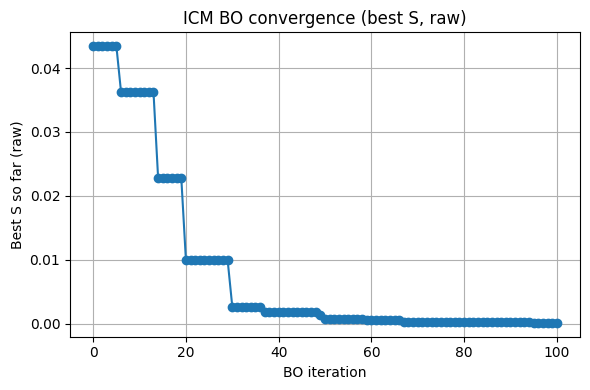

In [22]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(len(S_history_raw))

plt.figure(figsize=(6,4))
plt.plot(iters, S_history_raw, marker="o")
plt.xlabel("BO iteration")
plt.ylabel("Best S so far (raw)")
plt.title("ICM BO convergence (best S, raw)")
plt.grid(True)
plt.tight_layout()
plt.show()

Best OD index: 86
Best OD vector: [492.08228 510.5559  911.1657  895.6348 ]
GT OD vector:  [500. 500. 900. 900.]


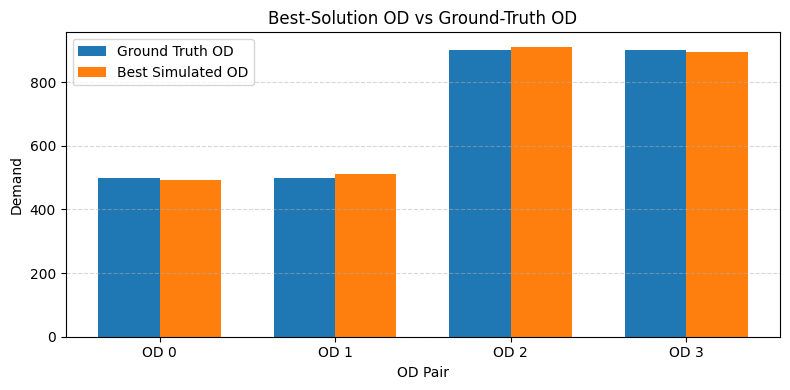

In [23]:
import numpy as np
import matplotlib.pyplot as plt


best_idx = int(np.argmin(S_obs_history_raw))
best_od = train_X_icm[best_idx].cpu().numpy() 

# Ground truth OD
gt_od = gt_od_df["count"].astype(float).values  

print("Best OD index:", best_idx)
print("Best OD vector:", best_od)
print("GT OD vector: ", gt_od)


labels = [f"OD {i}" for i in range(len(gt_od))]

x = np.arange(len(gt_od))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, gt_od,  width, label="Ground Truth OD")
plt.bar(x + width/2, best_od, width, label="Best Simulated OD")

plt.xlabel("OD Pair")
plt.ylabel("Demand")
plt.title("Best-Solution OD vs Ground-Truth OD")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
# Check the actual noise structure
likelihood = icm_model.likelihood
print(f"Likelihood type: {type(likelihood)}")
print(f"Likelihood num_tasks: {likelihood.num_tasks}")

# Check different noise attributes
print(f"\nNoise attributes:")
print(f"  noise: {likelihood.noise.shape if hasattr(likelihood.noise, 'shape') else 'scalar'}")
print(f"  noise.data: {likelihood.noise.data.shape if hasattr(likelihood.noise.data, 'shape') else 'scalar'}")

# Try accessing task-specific noise if it exists
if hasattr(likelihood, 'task_noises'):
    print(f"  task_noises: {likelihood.task_noises.shape if hasattr(likelihood.task_noises, 'shape') else 'N/A'}")
    print(f"  task_noises.data: {likelihood.task_noises.data}")

# List all attributes
print(f"\nAll likelihood attributes containing 'noise':")
for attr in dir(likelihood):
    if 'noise' in attr.lower():
        try:
            val = getattr(likelihood, attr)
            if not callable(val):
                print(f"  {attr}: {val}")
        except:
            pass

Likelihood type: <class 'gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood'>
Likelihood num_tasks: 14

Noise attributes:
  noise: torch.Size([1])
  noise.data: torch.Size([1])
  task_noises: torch.Size([14])
  task_noises.data: tensor([0.0001, 0.0006, 0.0001, 0.0001, 0.0001, 0.0001, 0.0055, 0.0002, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0478, 0.0001])

All likelihood attributes containing 'noise':
  has_global_noise: True
  has_task_noise: True
  noise: tensor([1.0000e-04], grad_fn=<AddBackward0>)
  raw_noise: Parameter containing:
tensor([-35.2862], requires_grad=True)
  raw_task_noises: Parameter containing:
tensor([-10.0328,  -7.5298, -12.2299, -11.1129, -11.1465, -11.0297,  -5.2104,
         -9.7758, -10.6089, -12.6073, -13.3319, -10.6181,  -2.9934, -12.2003],
       requires_grad=True)
  task_noises: tensor([0.0001, 0.0006, 0.0001, 0.0001, 0.0001, 0.0001, 0.0055, 0.0002, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0478, 0.0001], grad_fn=<AddBackward0>

In [25]:
# Check task-specific noise (this is what you want!)
task_noises = icm_model.likelihood.task_noises.data
num_tasks = len(task_noises)

print(f"Number of tasks (edges): {num_tasks}")
print(f"\nNoise per task:")
print("-" * 50)
for task_idx in range(num_tasks):
    noise_val = task_noises[task_idx].item()
    status = ""
    if abs(noise_val - 1e-4) < 1e-5:
        status = " LOWER LIMIT"
    elif abs(noise_val - 1.0) < 1e-5:
        status = "  UPPER LIMIT"
    print(f"  Task {task_idx:3d}: {noise_val:.6f}{status}")

print("-" * 50)
print(f"Summary: min={task_noises.min():.6f}, max={task_noises.max():.6f}, mean={task_noises.mean():.6f}")

# Check limits
lower_bound = 1e-4
upper_bound = 1.0
at_lower = (task_noises - lower_bound).abs() < 1e-5
at_upper = (task_noises - upper_bound).abs() < 1e-5

if at_lower.any():
    task_indices = torch.where(at_lower)[0].tolist()
    print(f"\n  {at_lower.sum()} task(s) at LOWER limit: tasks {task_indices}")
if at_upper.any():
    task_indices = torch.where(at_upper)[0].tolist()
    print(f"  {at_upper.sum()} task(s) at UPPER limit: tasks {task_indices}")

Number of tasks (edges): 14

Noise per task:
--------------------------------------------------
  Task   0: 0.000144
  Task   1: 0.000637
  Task   2: 0.000105 LOWER LIMIT
  Task   3: 0.000115
  Task   4: 0.000114
  Task   5: 0.000116
  Task   6: 0.005529
  Task   7: 0.000157
  Task   8: 0.000125
  Task   9: 0.000103 LOWER LIMIT
  Task  10: 0.000102 LOWER LIMIT
  Task  11: 0.000124
  Task  12: 0.047822
  Task  13: 0.000105 LOWER LIMIT
--------------------------------------------------
Summary: min=0.000102, max=0.047822, mean=0.003950

  4 task(s) at LOWER limit: tasks [2, 9, 10, 13]


In [26]:
# B matrix (task covariance / coregionalization)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
print("B shape:", B.shape)
print(B)

B shape: torch.Size([14, 14])
tensor([[ 45.9344,  26.7408,  21.7835,   1.2208,  -1.8754, -14.7223,  -2.6247,
          22.4760, -30.4669,  -9.0068, -10.0300,   4.2916,  17.0452,   1.3113],
        [ 26.7408,  98.3896,  24.6659,  16.9757,  41.0839,  50.8946,  44.3089,
          40.9725,  32.4830,   9.5675,   4.6784,  68.5721,  49.2026, -18.8138],
        [ 21.7835,  24.6659,  13.9198,   3.1053,   5.8239,   2.5770,   5.2854,
          14.2990,  -6.3386,  -2.0436,  -3.4099,   9.5400,  11.3731,  -1.8225],
        [  1.2208,  16.9757,   3.1053,   5.8048,   8.5689,  11.8360,   9.1268,
           6.0093,   9.6059,   2.7955,   1.8517,  12.9036,   7.7263,  -3.8161],
        [ -1.8754,  41.0839,   5.8239,   8.5689,  24.6502,  32.7210,  23.9891,
          12.9096,  28.7122,   8.3269,   5.9199,  32.4566,  17.4378,  -9.9580],
        [-14.7223,  50.8946,   2.5770,  11.8360,  32.7210,  51.0922,  34.6168,
          12.0338,  49.1368,  14.2524,  11.0540,  44.1681,  19.3603, -14.3337],
        [ -2.624

In [27]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])
print(corr)

tensor([[ 1.0000,  0.3978,  0.8615,  0.0748, -0.0557, -0.3039, -0.0728,  0.6614,
         -0.6047, -0.5243, -0.6468,  0.0798,  0.4297,  0.0757],
        [ 0.3978,  1.0000,  0.6665,  0.7103,  0.8342,  0.7178,  0.8394,  0.8238,
          0.4406,  0.3805,  0.2061,  0.8713,  0.8476, -0.7424],
        [ 0.8615,  0.6665,  1.0000,  0.3455,  0.3144,  0.0966,  0.2662,  0.7644,
         -0.2286, -0.2161, -0.3994,  0.3223,  0.5209, -0.1912],
        [ 0.0748,  0.7103,  0.3455,  1.0000,  0.7163,  0.6873,  0.7118,  0.4974,
          0.5364,  0.4577,  0.3359,  0.6750,  0.5480, -0.6200],
        [-0.0557,  0.8342,  0.3144,  0.7163,  1.0000,  0.9220,  0.9079,  0.5186,
          0.7780,  0.6616,  0.5211,  0.8239,  0.6001, -0.7851],
        [-0.3039,  0.7178,  0.0966,  0.6873,  0.9220,  1.0000,  0.9100,  0.3358,
          0.9248,  0.7866,  0.6759,  0.7788,  0.4628, -0.7849],
        [-0.0728,  0.8394,  0.2662,  0.7118,  0.9079,  0.9100,  1.0000,  0.5376,
          0.7692,  0.6661,  0.5451,  0.8835,  0.6

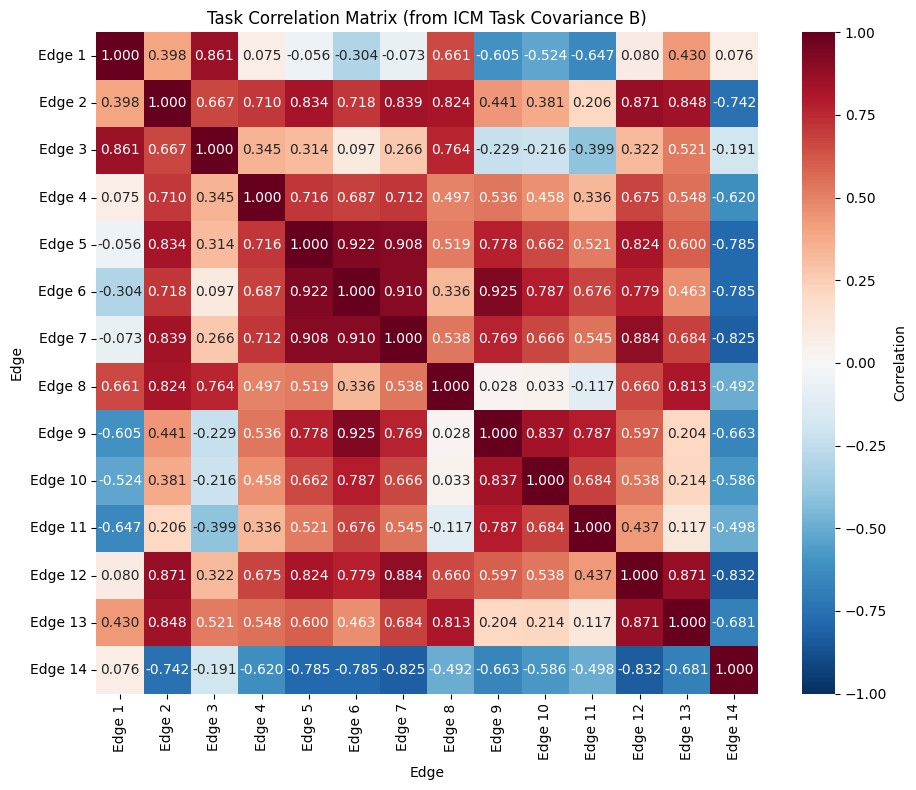

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B)) # 
    corr = B / (d[:, None] * d[None, :])

# Convert to numpy for plotting
corr_np = corr.detach().cpu().numpy()



#Heat map 
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=[f'Edge {i+1}' for i in range(L)],
    yticklabels=[f'Edge {i+1}' for i in range(L)],
)
plt.title('Task Correlation Matrix (from ICM Task Covariance B)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.tight_layout()
plt.show()


In [29]:
edge_ids = gt_edge_data["edge_id"].tolist()

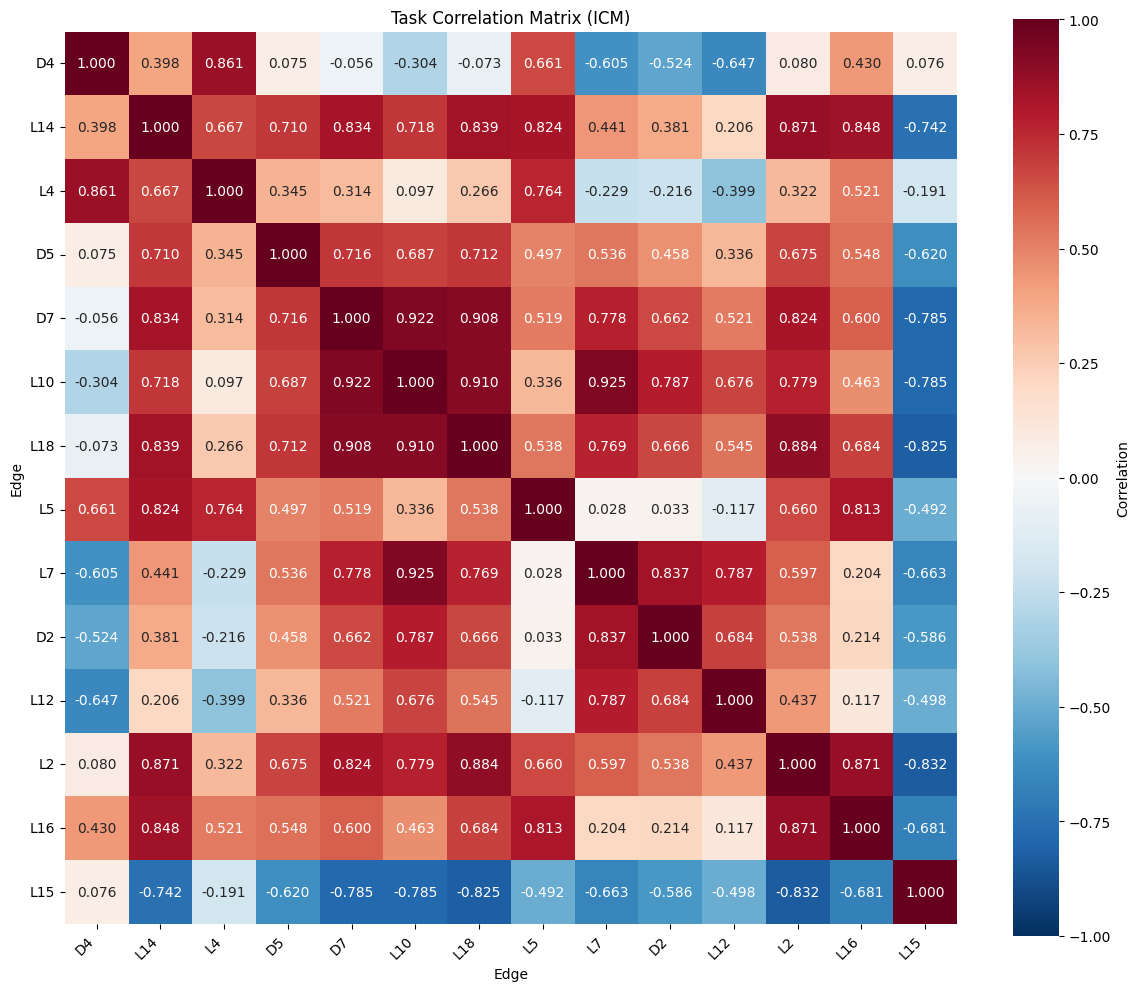

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Compute correlation (your existing code)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

corr_np = corr.detach().cpu().numpy()

# Create heatmap with edge IDs as labels
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=edge_ids,  # Use actual edge IDs
    yticklabels=edge_ids,
)
plt.title('Task Correlation Matrix (ICM)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.xticks(rotation=45, ha='right')  # Rotate labels if needed
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## comparing scalar gp with icm 

In [31]:
print(train_X_icm_init)

tensor([[1995.0267,  208.7328, 1645.9578,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3398],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2373],
        [ 208.3256, 1373.7338, 1810.7881,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4969],
        [1642.0144, 1849.8972, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8531, 1135.5953, 1953.6954],
        [  97.3469,   66.7411,  384.3306,  587.1246],
        [1006.2524, 1536.8247, 1885.7072, 1482.5537],
        [1357.3130,  396.7292, 1282.7886, 1120.7015],
        [ 257.9750, 1991.8317,  784.0896,  949.7550],
        [ 790.8787,  889.4018, 1532.9441, 1567.5588],
        [1824.3027, 1483.7563,   33.9629,  486.5554],
        [1770.7188,  937.5904, 1217.8479, 1300.8279],
        [ 860.3464, 1408.1616,  715.2431,  628.0270],
        [ 329.1326,  461.825

In [32]:
#same
print(train_X_icm_init[1])
print(train_X_icm[1])


tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])
tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])


In [33]:
"""
GP Hyperparameter Optimization Process:

1. ExactMarginalLogLikelihood (MLL):
   - Computes the marginal log-likelihood: log p(Y | X, θ)
   - Evaluates how well the model explains the data given current hyperparameters θ
   - Provides gradients for optimization
   
   Example:
       mll = ExactMarginalLogLikelihood(model.likelihood, model)
       current_mll = mll()  # log p(Y | X, θ_current)

2. fit_gpytorch_mll:
   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)
   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)
   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)
   
   Example:
       fit_gpytorch_mll(mll)  # Optimizes hyperparameters
       # After fitting, model has optimized θ*

Hyperparameters optimized:
   - Kernel: lengthscales ℓ, output variance σ²_f
   - Task covariance: matrix B (rank-1: parameters b)
   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]
   - Mean: per-task mean μ = [μ₁, ..., μ_L]
"""

'\nGP Hyperparameter Optimization Process:\n\n1. ExactMarginalLogLikelihood (MLL):\n   - Computes the marginal log-likelihood: log p(Y | X, θ)\n   - Evaluates how well the model explains the data given current hyperparameters θ\n   - Provides gradients for optimization\n\n   Example:\n       mll = ExactMarginalLogLikelihood(model.likelihood, model)\n       current_mll = mll()  # log p(Y | X, θ_current)\n\n2. fit_gpytorch_mll:\n   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)\n   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)\n   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)\n\n   Example:\n       fit_gpytorch_mll(mll)  # Optimizes hyperparameters\n       # After fitting, model has optimized θ*\n\nHyperparameters optimized:\n   - Kernel: lengthscales ℓ, output variance σ²_f\n   - Task covariance: matrix B (rank-1: parameters b)\n   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]\n   - Mean: per-task mean μ = [μ₁, ..., μ_L]\n'

In [34]:
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
import numpy as np
from src.models.gp_models import initialize_vanillabo_model
from src.utils.seed import set_seed

if "train_X_icm_init" not in locals():
    train_X_icm_init = train_X_icm.clone()
if "train_Y_icm_raw_init" not in locals():
    train_Y_icm_raw_init = train_Y_icm_raw.clone()

weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

vanilla_histories_raw = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"  {r+1}/{N_RESTARTS}")
    print("============================\n")

    ##
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")
    ###


    train_X_van = train_X_icm_init.clone()

    # Aggregate initial per-edge errors into a single scalar S for scalar gp ( vanilla bo ) target 
    train_Y_raw_van = (train_Y_icm_raw_init * weights_uniform).sum(dim=1) 

    S_raw_all = train_Y_raw_van 
    best_S_raw = S_raw_all.min().item()

    S_history_raw_van = [best_S_raw]
    S_obs_history_raw_van = S_raw_all.detach().cpu().tolist()

    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"    VANILLA BO ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")


        # Fit vanilla GP on aggregated S (outcome_transform handles standardization)
        train_X_norm_van = normalize(train_X_van, bounds=bounds)


        model = initialize_vanillabo_model(train_X_norm_van, S_raw_all.unsqueeze(-1), kernel="matern-2p5")
        # raw values as outcome trasnform handles standardization 
        



        #### fitting the gp : finding the best hyperparameters 
        mll = ExactMarginalLogLikelihood(model.likelihood, model) ## compute the marginal log likelihood 


        #fit_gpytorch_mll(mll)
        fit_gpytorch_mll_with_retries(  # maximize the marginal log likelihood with default optimizer L-BFGS-B
            mll,
            max_retries=3,
            base_jitter=1e-3,
            initial_jitter=0.0,
            jitter_multiplier=10.0,
            verbose=True,)

        model.eval() # making predictions



        ##### inference : compute the posterior mean and varaince at test points 
        EI = ExpectedImprovement(
            model=model, # EI call model.posterior internally, ExpectedImprovement is designed to work with a model that can compute posteriors at arbitrary points.
            best_f=best_S_raw,
            maximize=False,
        )

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )


        x_next_norm = x_next_norm.detach()

        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")

        # Run SUMO simulation for new od 
        sim_dir = f"{config['simulation_run_path']}/vanilla_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        # Compute aggregated loss 
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        curr_loss = compute_nrmse_counts_all_edges(
            gt_edge_data,
            curr_loop_stats,
        )
        S_next_raw = torch.tensor(curr_loss, device=device, dtype=dtype)

    
        S_obs_history_raw_van.append(S_next_raw.item())
        if S_next_raw.item() < best_S_raw:
            best_S_raw = S_next_raw.item()

        S_history_raw_van.append(best_S_raw)

        # Update training data
        train_X_van = torch.cat(
            [train_X_van, torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_raw_van = torch.cat(
            [train_Y_raw_van, S_next_raw.view(1)],
            dim=0,
        )
        S_raw_all = train_Y_raw_van

    vanilla_histories_raw.append(S_history_raw_van)

# Mean curve across restarts (raw)




min_len = min(len(h) for h in vanilla_histories_raw)
S_history_raw_van = np.mean([h[:min_len] for h in vanilla_histories_raw], axis=0).tolist()

print("\nFinished Vanilla BO.")
print(f"Final best S (raw, mean) = {S_history_raw_van[-1]:.6f}")




  1/3

[SEED] Set seed to 42 for restart 1


    VANILLA BO ITER 1/100

ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.26927277 0.42764223 0.         0.        ]]
[ACQ] Candidate OD (real space) = [538.54553 855.2844    0.        0.     ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenha

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 1393 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.32s
 Real time factor: 180564
 UPS: 1772354.231975
Vehicles:
 Inserted: 1393
 Running: 0
 Waiting: 0
Statistics (avg of 1393):
 RouteLength: 4348.75
 Speed: 10.73
 Duration: 405.87
 WaitingTime: 0.19
 TimeLoss: 87.51
 DepartDelay: 624.44
DijkstraRouter answered 2710 queries and explored 10.50 edges on average.
Dijk

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.3095684  0.21423894 0.42333782 0.46505037]]
[ACQ] Candidate OD (real space) = [619.13684 428.47787 846.67566 930.10077]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.36588693 0.05482345 0.41777003 0.46913108]]
[ACQ] Candidate OD (real space) = [731.77386  109.646904 835.54004  938.26215 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22023495 0.3198138  0.49850756 0.42011252]]
[ACQ] Candidate OD (real space) = [440.46988 639.62756 997.01514 840.22504]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.         0.46414608 0.70653784 0.26578853]]
[ACQ] Candidate OD (real space) = [   0.      928.2922 1413.0757  531.577 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22924283 0.27571246 0.55438673 0.43044353]]
[ACQ] Candidate OD (real space) = [ 458.48566  551.4249  1108.7734   860.887  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=c

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[ACQ] x_next_norm = [[0.10437179 0.229979   0.41124716 0.61081994]]
[ACQ] Candidate OD (real space) = [ 208.74359  459.95798  822.4943  1221.6399 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.04017343 0.50291485 0.01820986 0.8521931 ]]
[ACQ] Candidate OD (real space) = [  80.34687 1005.8297    36.41972 1704.3862 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.2546547  0.2458502  0.44296524 0.4627995 ]]
[ACQ] Candidate OD (real space) = [509.30942 491.7004  885.9305  925.599  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.41441724 0.18960541 0.00841774 0.6803738 ]]
[ACQ] Candidate OD (real space) = [ 828.8345    379.21082    16.835476 1360.7476  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.54
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3107716  0.0623487  0.03886533 0.63253844]]
[ACQ] Candidate OD (real space) = [ 621.5432   124.6974    77.73066 1265.0769 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33292663 0.00317449 0.4400396  0.18633628]]
[ACQ] Candidate OD (real space) = [665.8533      6.3489842 880.0792    372.67255  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.14294976 0.44897267 0.5146481  0.36210704]]
[ACQ] Candidate OD (real space) = [ 285.8995   897.9454  1029.2961   724.21405]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2989982 0.2277477 0.4790993 0.3813766]]
[ACQ] Candidate OD (real space) = [597.9964 455.4954 958.1986 762.7532]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_res

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.734288   0.01033207 0.06523938 0.6545979 ]]
[ACQ] Candidate OD (real space) = [1468.5759     20.664146  130.47878  1309.1958  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5121758  0.03357353 0.13274051 0.21097843]]
[ACQ] Candidate OD (real space) = [1024.3516    67.14706  265.48102  421.95688]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17767824 0.25236002 0.53574646 0.37252298]]
[ACQ] Candidate OD (real space) = [ 355.35648  504.72003 1071.4929   745.04596]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19956157 0.37029508 0.44791073 0.4240645 ]]
[ACQ] Candidate OD (real space) = [399.12314 740.59015 895.8215  848.12897]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.08740632 0.96157557 0.03520899 0.03670191]]
[ACQ] Candidate OD (real space) = [ 174.81264 1923.1511    70.41797   73.40383]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 298.99
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (5ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2260 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.44s
 Real time factor: 129730
 UPS: 2211150.900901
Vehicles:
 Inserted: 2260
 Running: 0
 Waiting: 0
Statistics (avg of 2260):
 RouteLength: 4619.95
 Speed: 10.66
 Duration: 434.40
 WaitingTime: 0.28
 TimeLoss: 96.80
 DepartDelay: 479.39
DijkstraRouter answered 4347 queries and explored 11.58 edges on average.
Dij

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.07942549 0.35238498 0.91086876 0.19736667]]
[ACQ] Candidate OD (real space) = [ 158.85098  704.76996 1821.7375   394.73334]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2950298  0.3782879  0.36236337 0.37777698]]
[ACQ] Candidate OD (real space) = [590.0596  756.5758  724.72675 755.55396]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29030162 0.26967672 0.3618059  0.4309269 ]]
[ACQ] Candidate OD (real space) = [580.6033  539.35345 723.61176 861.85376]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00998713 0.67149335 0.8899078  0.7711617 ]]
[ACQ] Candidate OD (real space) = [  19.974264 1342.9867   1779.8156   1542.3234  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8642705  0.31573007 0.40117905 0.2205921 ]]
[ACQ] Candidate OD (real space) = [1728.541    631.46014  802.3581   441.1842 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09113321 0.42814466 0.6750535  0.4222038 ]]
[ACQ] Candidate OD (real space) = [ 182.26642  856.2893  1350.1069   844.4076 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2249582  0.21563293 0.38805395 0.5194146 ]]
[ACQ] Candidate OD (real space) = [ 449.91638  431.26587  776.1079  1038.8292 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.90188134 0.37453145 0.3672293  0.57654756]]
[ACQ] Candidate OD (real space) = [1803.7627   749.06287  734.4586  1153.0951 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.71826154 0.44516602 0.4084898  0.737452  ]]
[ACQ] Candidate OD (real space) = [1436.5231   890.33203  816.9796  1474.9039 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4618 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.30s
 Real time factor: 44376
 UPS: 1540714.175655
Vehicles:
 Inserted: 4618
 Running: 0
 Waiting: 0
Statistics (avg of 4618):
 RouteLength: 4587.35
 Speed: 10.61
 Duration: 433.05
 WaitingTime: 0.33
 TimeLoss: 98.08
 DepartDelay: 1139.58
DijkstraRouter answered 9092 queries and explored 11.48 edges on average.
Dij

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17962332 0.32020167 0.441066   0.43056554]]
[ACQ] Candidate OD (real space) = [359.24664 640.4033  882.132   861.13104]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.23534961 0.5363521  0.38779905 0.516118  ]]
[ACQ] Candidate OD (real space) = [ 470.69922 1072.7042   775.5981  1032.236  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18571018 0.27174947 0.48366717 0.5054955 ]]
[ACQ] Candidate OD (real space) = [ 371.42035  543.49896  967.33435 1010.99097]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.45077986 0.01941467 0.01781992 0.94192606]]
[ACQ] Candidate OD (real space) = [ 901.5597     38.829334   35.63984  1883.8522  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.907129   0.6544561  0.6539813  0.42554253]]
[ACQ] Candidate OD (real space) = [1814.2579 1308.9121 1307.9626  851.0851]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24332997 0.20443487 0.3550376  0.5537838 ]]
[ACQ] Candidate OD (real space) = [ 486.65994  408.86975  710.0752  1107.5675 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.26265404 0.19773746 0.93607503 0.8546108 ]]
[ACQ] Candidate OD (real space) = [ 525.30804  395.4749  1872.15    1709.2216 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7051038  0.29000407 0.20770486 0.57864326]]
[ACQ] Candidate OD (real space) = [1410.2076   580.0082   415.40973 1157.2865 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28474924 0.704933   0.75013536 0.25466654]]
[ACQ] Candidate OD (real space) = [ 569.4985  1409.866   1500.2708   509.33307]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7379134  0.5552177  0.20930052 0.34556636]]
[ACQ] Candidate OD (real space) = [1475.8269  1110.4354   418.60104  691.13275]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.250318   0.20632148 0.47330734 0.38361612]]
[ACQ] Candidate OD (real space) = [500.636   412.64294 946.6147  767.23224]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 298.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35438257 0.6549612  0.09545647 0.595575  ]]
[ACQ] Candidate OD (real space) = [ 708.76514 1309.9225   190.91295 1191.1499 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28754988 0.19809595 0.5097945  0.50123936]]
[ACQ] Candidate OD (real space) = [ 575.0998  396.1919 1019.5889 1002.4787]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01601761 0.52734464 0.18541232 0.16023555]]
[ACQ] Candidate OD (real space) = [  32.035217 1054.6893    370.82465   320.4711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.22391686 0.02895422 0.44879463 0.9547542 ]]
[ACQ] Candidate OD (real space) = [ 447.8337     57.908447  897.5893   1909.5083  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.26376542 0.3911935  0.56405264 0.33976617]]
[ACQ] Candidate OD (real space) = [ 527.5308   782.387   1128.1052   679.53235]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33609706 0.21711257 0.42617282 0.4139412 ]]
[ACQ] Candidate OD (real space) = [672.19415 434.22513 852.34564 827.8824 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.37514913 0.64483184 0.294887   0.7944211 ]]
[ACQ] Candidate OD (real space) = [ 750.2983 1289.6637  589.774  1588.8422]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.94819504 0.16611302 0.2490771  0.9139722 ]]
[ACQ] Candidate OD (real space) = [1896.3901   332.22604  498.1542  1827.9445 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35900423 0.0956488  0.25083625 0.5200025 ]]
[ACQ] Candidate OD (real space) = [ 718.0085   191.2976   501.67252 1040.005  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.2692736  0.05281329 0.33501935 0.6039578 ]]
[ACQ] Candidate OD (real space) = [ 538.54724  105.62659  670.0387  1207.9155 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.77107227 0.99408406 0.25785813 0.32359666]]
[ACQ] Candidate OD (real space) = [1542.1445  1988.1681   515.71625  647.1933 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 298.93
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01829889 0.69740814 0.5844007  0.41541123]]
[ACQ] Candidate OD (real space) = [  36.597775 1394.8163   1168.8014    830.82245 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.16245347 0.37531087 0.43694985 0.2458001 ]]
[ACQ] Candidate OD (real space) = [324.90695 750.62177 873.8997  491.6002 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5381972  0.37518212 0.74569774 0.5355592 ]]
[ACQ] Candidate OD (real space) = [1076.3944   750.36426 1491.3955  1071.1184 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28567076 0.2377349  0.3854788  0.39719248]]
[ACQ] Candidate OD (real space) = [571.3415  475.4698  770.9576  794.38495]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7835844  0.65505266 0.8738907  0.24458514]]
[ACQ] Candidate OD (real space) = [1567.1688 1310.1053 1747.7814  489.1703]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9062126  0.28910366 0.54645514 0.7567874 ]]
[ACQ] Candidate OD (real space) = [1812.4253   578.20734 1092.9103  1513.5748 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25618127 0.22165959 0.32002506 0.44041872]]
[ACQ] Candidate OD (real space) = [512.36255 443.31918 640.0501  880.83746]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.60809255 0.28180876 0.5177883  0.2186479 ]]
[ACQ] Candidate OD (real space) = [1216.185    563.61755 1035.5765   437.2958 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21195461 0.22060652 0.46419552 0.55849576]]
[ACQ] Candidate OD (real space) = [ 423.9092   441.21304  928.39105 1116.9916 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16856974 0.32989797 0.51160616 0.42747316]]
[ACQ] Candidate OD (real space) = [ 337.1395   659.79596 1023.21234  854.9463 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18173817 0.28517985 0.845913   0.9626927 ]]
[ACQ] Candidate OD (real space) = [ 363.47635  570.3597  1691.8259  1925.3854 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3368414  0.19208866 0.42804897 0.5007795 ]]
[ACQ] Candidate OD (real space) = [ 673.6828   384.17734  856.09796 1001.559  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00835887 0.02955176 0.31237707 0.7094255 ]]
[ACQ] Candidate OD (real space) = [  16.717731   59.103523  624.75415  1418.8511  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.26
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09448539 0.34869644 0.33753258 0.4680253 ]]
[ACQ] Candidate OD (real space) = [188.97078 697.3929  675.0652  936.0506 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.51558715 0.56973505 0.23881964 0.7001257 ]]
[ACQ] Candidate OD (real space) = [1031.1743  1139.4701   477.63928 1400.2513 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5171855  0.03544465 0.7305676  0.16798943]]
[ACQ] Candidate OD (real space) = [1034.371     70.8893  1461.1351   335.97885]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16634762 0.30296922 0.6644406  0.3646403 ]]
[ACQ] Candidate OD (real space) = [ 332.69525  605.9384  1328.8811   729.2806 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.27073127 0.20153439 0.39408618 0.57987845]]
[ACQ] Candidate OD (real space) = [ 541.4625   403.0688   788.17236 1159.757  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33635253 0.25678185 0.33107626 0.60004807]]
[ACQ] Candidate OD (real space) = [ 672.7051  513.5637  662.1525 1200.0962]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.38605306 0.04383963 0.3472756  0.6202289 ]]
[ACQ] Candidate OD (real space) = [ 772.10614   87.67926  694.5512  1240.4578 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00206747 0.40793988 0.5938441  0.6209141 ]]
[ACQ] Candidate OD (real space) = [   4.1349473  815.87976   1187.6882    1241.8282   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/ne

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.00586286 0.8350357  0.95023835 0.0816812 ]]
[ACQ] Candidate OD (real space) = [  11.725713 1670.0714   1900.4767    163.3624  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17935027 0.37101147 0.5454151  0.36635378]]
[ACQ] Candidate OD (real space) = [ 358.70053  742.02295 1090.8302   732.7076 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03593468 0.9565298  0.04731014 0.92759484]]
[ACQ] Candidate OD (real space) = [  71.86937  1913.0596     94.620285 1855.1897  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02642471 0.74203265 0.4632082  0.06222977]]
[ACQ] Candidate OD (real space) = [  52.849426 1484.0653    926.4164    124.45953 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8769613  0.20943916 0.15045977 0.25111344]]
[ACQ] Candidate OD (real space) = [1753.9226   418.87833  300.91953  502.2269 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29367498 0.10971624 0.42144403 0.5782659 ]]
[ACQ] Candidate OD (real space) = [ 587.35     219.43248  842.88806 1156.5319 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9722222  0.31039953 0.5830242  0.11370039]]
[ACQ] Candidate OD (real space) = [1944.4445   620.7991  1166.0485   227.40079]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.31996453 0.23313428 0.53425306 0.6190383 ]]
[ACQ] Candidate OD (real space) = [ 639.9291   466.26855 1068.5061  1238.0765 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6998856  0.7829651  0.51594794 0.27802604]]
[ACQ] Candidate OD (real space) = [1399.7712  1565.9303  1031.8959   556.05206]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

[ACQ] x_next_norm = [[0.26915252 0.42717645 0.         0.        ]]
[ACQ] Candidate OD (real space) = [538.30505 854.3529    0.        0.     ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_0/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.3092274  0.21516284 0.42379943 0.4643535 ]]
[ACQ] Candidate OD (real space) = [618.45483 430.32568 847.5989  928.70703]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_1/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.36496088 0.06027656 0.4180395  0.46946546]]
[ACQ] Candidate OD (real space) = [729.92175  120.553116 836.079    938.9309  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_2/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.34265292 0.20215869 0.3214992  0.47778916]]
[ACQ] Candidate OD (real space) = [685.30585 404.31738 642.9984  955.5783 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.22027513 0.32173797 0.49166116 0.41812775]]
[ACQ] Candidate OD (real space) = [440.55026 643.47595 983.3223  836.2555 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.         0.46480602 0.70165503 0.25517747]]
[ACQ] Candidate OD (real space) = [   0.       929.61206 1403.31     510.35495]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.21199374 0.14428256 0.33143705 0.82224786]]
[ACQ] Candidate OD (real space) = [ 423.9875   288.56512  662.8741  1644.4957 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_7/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.16676255 0.2903202  0.65015864 0.20311704]]
[ACQ] Candidate OD (real space) = [ 333.5251  580.6404 1300.3173  406.2341]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_9/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3112 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.84s
 Real time factor: 68489.9
 UPS: 1562306.777646
Vehicles:
 Inserted: 3112
 Running: 0
 Waiting: 0
Statistics (avg of 3112):
 RouteLength: 4437.65
 Speed: 10.55
 Duration: 422.20
 WaitingTime: 0.33
 TimeLoss: 97.74
 DepartDelay: 725.92
DijkstraRouter answered 6069 queries and explored 10.87 edges on average.
Dij

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.39492038 0.22093903 0.1756888  0.5750951 ]]
[ACQ] Candidate OD (real space) = [ 789.84076  441.87805  351.3776  1150.1902 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.18186095 0.07195166 0.8360633  0.03448691]]
[ACQ] Candidate OD (real space) = [ 363.7219   143.90334 1672.1267    68.97382]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_15/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=c

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[ACQ] x_next_norm = [[0.26064306 0.27396137 0.46693003 0.445611  ]]
[ACQ] Candidate OD (real space) = [521.28613 547.9227  933.86005 891.222  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.3851855  0.04051441 0.05478947 0.6204009 ]]
[ACQ] Candidate OD (real space) = [ 770.37103   81.02881  109.57894 1240.8018 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0603756  0.5881501  0.1715742  0.12810056]]
[ACQ] Candidate OD (real space) = [ 120.7512 1176.3002  343.1484  256.2011]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21430431 0.51764697 0.47619885 0.08785181]]
[ACQ] Candidate OD (real space) = [ 428.6086  1035.294    952.3977   175.70363]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 298.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3708929  0.03963912 0.71438247 0.4301583 ]]
[ACQ] Candidate OD (real space) = [ 741.7858     79.278244 1428.7649    860.3166  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2260392  0.28068945 0.0677515  0.9155739 ]]
[ACQ] Candidate OD (real space) = [ 452.0784   561.3789   135.50299 1831.1478 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21712345 0.27370027 0.73488146 0.55134994]]
[ACQ] Candidate OD (real space) = [ 434.2469  547.4005 1469.763  1102.6998]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_24/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.11231761 0.4930635  0.55765575 0.26550582]]
[ACQ] Candidate OD (real space) = [ 224.63521  986.127   1115.3115   531.01166]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.13592209 0.3611558  0.07674518 0.5573126 ]]
[ACQ] Candidate OD (real space) = [ 271.84418  722.31165  153.49037 1114.6252 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_26/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18704608 0.08288925 0.56391144 0.6644816 ]]
[ACQ] Candidate OD (real space) = [ 374.09216  165.7785  1127.8229  1328.9631 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.07
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6013411  0.03287814 0.36941308 0.9240423 ]]
[ACQ] Candidate OD (real space) = [1202.6823    65.75628  738.8262  1848.0846 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29830688 0.05114356 0.24729271 0.5524933 ]]
[ACQ] Candidate OD (real space) = [ 596.6138   102.28712  494.58542 1104.9866 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.14257246 0.2916449  0.4479231  0.4654125 ]]
[ACQ] Candidate OD (real space) = [285.14493 583.2898  895.8462  930.825  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.31554085 0.19798847 0.34239098 0.58170056]]
[ACQ] Candidate OD (real space) = [ 631.0817   395.97693  684.782   1163.4011 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.07012044 0.48113623 0.7057324  0.39310503]]
[ACQ] Candidate OD (real space) = [ 140.24088  962.27246 1411.4648   786.2101 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.00629476 0.77057314 0.43335414 0.47553405]]
[ACQ] Candidate OD (real space) = [  12.5895195 1541.1462     866.70825    951.0681   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/ne

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01668596 0.855424   0.9788559  0.25430712]]
[ACQ] Candidate OD (real space) = [  33.37192 1710.848   1957.7118   508.61423]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3720008  0.27003047 0.4224545  0.43811896]]
[ACQ] Candidate OD (real space) = [744.00165 540.0609  844.909   876.2379 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.49422786 0.01280881 0.09794652 0.11108717]]
[ACQ] Candidate OD (real space) = [988.4557   25.61762 195.89305 222.17435]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 298.94
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6226486  0.8664294  0.8387138  0.40631694]]
[ACQ] Candidate OD (real space) = [1245.2972  1732.8588  1677.4276   812.63385]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28580844 0.24736544 0.59255904 0.39029047]]
[ACQ] Candidate OD (real space) = [ 571.6169   494.7309  1185.118    780.58093]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24259141 0.21748541 0.4180949  0.3508836 ]]
[ACQ] Candidate OD (real space) = [485.18283 434.97083 836.1898  701.7672 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.36
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2953076  0.24062297 0.49932924 0.43585593]]
[ACQ] Candidate OD (real space) = [590.61523 481.24594 998.6585  871.71185]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24945107 0.32218134 0.49950987 0.47889727]]
[ACQ] Candidate OD (real space) = [498.90213 644.3627  999.0197  957.79456]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.36553907 0.19732493 0.38064888 0.46392292]]
[ACQ] Candidate OD (real space) = [731.0781  394.64987 761.2978  927.8458 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_42/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18904695 0.01709545 0.17868312 0.92842424]]
[ACQ] Candidate OD (real space) = [ 378.0939     34.190907  357.36624  1856.8485  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6505009  0.27624097 0.63852596 0.723508  ]]
[ACQ] Candidate OD (real space) = [1301.0018   552.48193 1277.0519  1447.016  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.65
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25294384 0.36857325 0.36240214 0.30557713]]
[ACQ] Candidate OD (real space) = [505.8877  737.1465  724.80426 611.15424]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21597604 0.20808601 0.4141669  0.39882472]]
[ACQ] Candidate OD (real space) = [431.9521  416.17203 828.3338  797.6494 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.93241566 0.72982115 0.3008837  0.43340078]]
[ACQ] Candidate OD (real space) = [1864.8313 1459.6423  601.7674  866.8016]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16589275 0.39553946 0.74754286 0.3301366 ]]
[ACQ] Candidate OD (real space) = [ 331.7855  791.0789 1495.0857  660.2732]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19834644 0.34325528 0.44574887 0.34822118]]
[ACQ] Candidate OD (real space) = [396.69287 686.51056 891.49774 696.4424 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2258755  0.26803303 0.41628557 0.3654649 ]]
[ACQ] Candidate OD (real space) = [451.751   536.06604 832.57117 730.9298 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6611525 0.3401653 0.7471325 0.8074384]]
[ACQ] Candidate OD (real space) = [1322.3049   680.33057 1494.265   1614.8767 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3616859  0.00724772 0.00314623 0.8866129 ]]
[ACQ] Candidate OD (real space) = [ 723.3718      14.495441     6.2924547 1773.2258   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/ne

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16568351 0.22494914 0.5229231  0.49512112]]
[ACQ] Candidate OD (real space) = [ 331.367    449.8983  1045.8462   990.24225]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02138793 0.00198229 0.9842622  0.6009297 ]]
[ACQ] Candidate OD (real space) = [  42.775864     3.9645731 1968.5244    1201.8594   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/ne

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.38709202 0.048508   0.5114908  0.6735883 ]]
[ACQ] Candidate OD (real space) = [ 774.184     97.01601 1022.9816  1347.1765 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.27491105 0.20251237 0.50165445 0.46653458]]
[ACQ] Candidate OD (real space) = [ 549.8221   405.02475 1003.3089   933.06915]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.52
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25946903 0.37670264 0.53261954 0.32484895]]
[ACQ] Candidate OD (real space) = [ 518.93805  753.4053  1065.239    649.6979 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.06346633 0.7558399  0.03368598 0.96348   ]]
[ACQ] Candidate OD (real space) = [ 126.93265 1511.6798    67.37196 1926.96   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2910788  0.13757725 0.53814656 0.5370689 ]]
[ACQ] Candidate OD (real space) = [ 582.1576  275.1545 1076.2931 1074.1378]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3050802  0.19794752 0.483289   0.44569138]]
[ACQ] Candidate OD (real space) = [610.1604  395.89502 966.578   891.38275]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01202661 0.66353637 0.7140228  0.14557718]]
[ACQ] Candidate OD (real space) = [  24.05322 1327.0728  1428.0457   291.15436]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8098605  0.6044343  0.20821542 0.64829826]]
[ACQ] Candidate OD (real space) = [1619.7211  1208.8687   416.43082 1296.5966 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.54
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24605516 0.23047684 0.2712669  0.45027438]]
[ACQ] Candidate OD (real space) = [492.11032 460.95367 542.5338  900.54877]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.23729281 0.26191854 0.57029593 0.38088027]]
[ACQ] Candidate OD (real space) = [ 474.58563  523.8371  1140.5919   761.76056]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.523912   0.00119133 0.41503268 0.5063163 ]]
[ACQ] Candidate OD (real space) = [1047.824        2.3826678  830.06537   1012.6326   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01573486 0.9469316  0.967434   0.07254286]]
[ACQ] Candidate OD (real space) = [  31.469717 1893.8632   1934.8679    145.08572 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30307043 0.20723598 0.34385547 0.52408284]]
[ACQ] Candidate OD (real space) = [ 606.14087  414.47195  687.71094 1048.1656 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.26
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.871292   0.44156015 0.16108873 0.38038385]]
[ACQ] Candidate OD (real space) = [1742.584    883.1203   322.17746  760.7677 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.96129423 0.8811236  0.30257082 0.96002847]]
[ACQ] Candidate OD (real space) = [1922.5885  1762.2472   605.14166 1920.0569 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.45915616 0.21422817 0.04916195 0.35390875]]
[ACQ] Candidate OD (real space) = [918.3123   428.45633   98.323906 707.8175  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.36
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.04420409 0.94309086 0.1650119  0.00584448]]
[ACQ] Candidate OD (real space) = [  88.40819  1886.1818    330.0238     11.688965]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9378229  0.34810805 0.8308856  0.5931432 ]]
[ACQ] Candidate OD (real space) = [1875.6458  696.2161 1661.7711 1186.2865]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30602875 0.1457862  0.38133904 0.48398277]]
[ACQ] Candidate OD (real space) = [612.0575 291.5724 762.6781 967.9655]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.1437594  0.28859594 0.5987163  0.4504426 ]]
[ACQ] Candidate OD (real space) = [ 287.5188   577.1919  1197.4326   900.88525]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24674585 0.19125433 0.3890564  0.5470522 ]]
[ACQ] Candidate OD (real space) = [ 493.4917   382.50867  778.11285 1094.1044 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.31
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30323792 0.34168667 0.31982535 0.47220215]]
[ACQ] Candidate OD (real space) = [606.4758  683.37335 639.6507  944.4043 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21793525 0.28977123 0.48201454 0.36369985]]
[ACQ] Candidate OD (real space) = [435.87048 579.5425  964.02905 727.3997 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03830541 0.35321903 0.30953747 0.03118758]]
[ACQ] Candidate OD (real space) = [ 76.61081  706.43805  619.07495   62.375156]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 298.94
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.833895   0.69353896 0.5422229  0.4591562 ]]
[ACQ] Candidate OD (real space) = [1667.79   1387.0779 1084.4458  918.3124]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.31
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19185115 0.6219644  0.27104896 0.8201404 ]]
[ACQ] Candidate OD (real space) = [ 383.7023 1243.9288  542.0979 1640.2809]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 298.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24920695 0.25111854 0.44943166 0.45105135]]
[ACQ] Candidate OD (real space) = [498.41388 502.2371  898.86334 902.1027 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29279175 0.25453115 0.4504853  0.40196723]]
[ACQ] Candidate OD (real space) = [585.5835  509.0623  900.9706  803.93445]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2953448  0.00255814 0.3610575  0.46008554]]
[ACQ] Candidate OD (real space) = [590.6896     5.116284 722.115    920.1711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0015868  0.73392004 0.7986838  0.6818149 ]]
[ACQ] Candidate OD (real space) = [   3.1735952 1467.8401    1597.3677    1363.6298   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.30921063 0.09882496 0.41045138 0.6883849 ]]
[ACQ] Candidate OD (real space) = [ 618.42126  197.64993  820.9028  1376.7698 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19724697 0.13957508 0.24304473 0.64133584]]
[ACQ] Candidate OD (real space) = [ 394.49393  279.15015  486.08948 1282.6716 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29518723 0.2769768  0.4180248  0.40224832]]
[ACQ] Candidate OD (real space) = [590.37445 553.9536  836.0496  804.49664]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25051042 0.24744768 0.44551063 0.45259088]]
[ACQ] Candidate OD (real space) = [501.02084 494.89536 891.02124 905.18176]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.0094454  0.87248844 0.8518957  0.15994154]]
[ACQ] Candidate OD (real space) = [  18.890797 1744.9769   1703.7914    319.8831  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_90/sim_trips.xml -b 0 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2487146  0.45040733 0.15467365 0.40600315]]
[ACQ] Candidate OD (real space) = [497.4292  900.81464 309.3473  812.0063 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35633206 0.57803154 0.9165281  0.02881446]]
[ACQ] Candidate OD (real space) = [ 712.6641  1156.0631  1833.0562    57.62893]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptima

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.53070945 0.46672016 0.21138155 0.80840516]]
[ACQ] Candidate OD (real space) = [1061.419    933.4403   422.76312 1616.8103 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21031544 0.07889882 0.7236903  0.34798828]]
[ACQ] Candidate OD (real space) = [ 420.63086  157.79764 1447.3805   695.97656]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.04564418 0.30788204 0.9556486  0.51658803]]
[ACQ] Candidate OD (real space) = [  91.28836  615.7641  1911.2972  1033.176  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.87750703 0.11519871 0.36221156 0.517531  ]]
[ACQ] Candidate OD (real space) = [1755.014    230.39742  724.4231  1035.062  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.57
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09380534 0.6819654  0.8783502  0.10578696]]
[ACQ] Candidate OD (real space) = [ 187.61069 1363.9308  1756.7004   211.57393]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17729476 0.2583576  0.4778675  0.45142916]]
[ACQ] Candidate OD (real space) = [354.5895  516.7152  955.73505 902.85834]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3056736  0.20105505 0.74914306 0.2612308 ]]
[ACQ] Candidate OD (real space) = [ 611.34717  402.1101  1498.2861   522.4616 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_1/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

[ACQ] x_next_norm = [[0.26973268 0.4266245  0.         0.        ]]
[ACQ] Candidate OD (real space) = [539.4654 853.249    0.       0.    ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_0/sim_trips.xml -b 0 -e 57600 --additi

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.30986407 0.21368533 0.42347282 0.46452716]]
[ACQ] Candidate OD (real space) = [619.72815 427.37067 846.9456  929.0543 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_1/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_2/sim_trips

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_3/sim_trips

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.25759673 0.24646558 0.483643   0.46715662]]
[ACQ] Candidate OD (real space) = [515.1935  492.93115 967.286   934.31323]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.52
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_4/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.17829661 0.11867234 0.8451255  0.04828602]]
[ACQ] Candidate OD (real space) = [ 356.59323  237.34468 1690.251     96.57205]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_5/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.         0.46786985 0.6929054  0.26588553]]
[ACQ] Candidate OD (real space) = [   0.       935.7397  1385.8108   531.77106]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWa

[ACQ] x_next_norm = [[0.15372166 0.4173317  0.51442915 0.25906205]]
[ACQ] Candidate OD (real space) = [ 307.44333  834.6634  1028.8583   518.1241 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_7/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_8/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_11/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_12/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_13/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.01261232 0.5693109  0.87290895 0.61729956]]
[ACQ] Candidate OD (real space) = [  25.224644 1138.6218   1745.8179   1234.5991  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.05770361 0.33117566 0.9761065  0.35634255]]
[ACQ] Candidate OD (real space) = [ 115.40723  662.3513  1952.213    712.6851 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_16/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2739 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.99s
 Real time factor: 58006
 UPS: 1224420.946626
Vehicles:
 Inserted: 2739
 Running: 0
 Waiting: 0
Statistics (avg of 2739):
 RouteLength: 4690.27
 Speed: 10.60
 Duration: 443.90
 WaitingTime: 0.32
 TimeLoss: 101.10
 DepartDelay: 646.80
DijkstraRouter answered 5315 queries and explored 11.89 edges on average.
Dij

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_17/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2602 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.72s
 Real time factor: 80559.4
 UPS: 1565986.013986
Vehicles:
 Inserted: 2602
 Running: 0
 Waiting: 0
Statistics (avg of 2602):
 RouteLength: 4605.31
 Speed: 10.73
 Duration: 430.31
 WaitingTime: 0.34
 TimeLoss: 93.87
 DepartDelay: 683.56
DijkstraRouter answered 5026 queries and explored 11.57 edges on average.
Di

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.23064375 0.23413008 0.42372328 0.5646962 ]]
[ACQ] Candidate OD (real space) = [ 461.2875   468.26016  847.44653 1129.3923 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_19/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.0115121  0.50306267 0.59421873 0.03907407]]
[ACQ] Candidate OD (real space) = [  23.0242  1006.1253  1188.4375    78.14813]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.11
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_22/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02215493 0.6126125  0.48323485 0.40431884]]
[ACQ] Candidate OD (real space) = [  44.30986 1225.225    966.4697   808.6377 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_24/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.21628915 0.18875238 0.5429904  0.47337714]]
[ACQ] Candidate OD (real space) = [ 432.5783   377.50476 1085.9807   946.7543 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18138438 0.69085294 0.4571492  0.0809281 ]]
[ACQ] Candidate OD (real space) = [ 362.76877 1381.7059   914.2984   161.8562 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.32401484 0.3776454  0.5085913  0.09470921]]
[ACQ] Candidate OD (real space) = [ 648.02966  755.29083 1017.1826   189.41843]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02149215 0.9078939  0.07762411 0.08123926]]
[ACQ] Candidate OD (real space) = [  42.98429 1815.7878   155.24823  162.47852]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.06821101 0.2833574  0.5034353  0.37553945]]
[ACQ] Candidate OD (real space) = [ 136.42203  566.71484 1006.8706   751.0789 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02612446 0.9728505  0.94968927 0.00234221]]
[ACQ] Candidate OD (real space) = [  52.248924 1945.701    1899.3785      4.684411]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2719298  0.2520509  0.28484133 0.5365324 ]]
[ACQ] Candidate OD (real space) = [ 543.8596  504.1018  569.6827 1073.0648]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_32/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2690 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.59s
 Real time factor: 97792.9
 UPS: 1957461.799660
Vehicles:
 Inserted: 2690
 Running: 0
 Waiting: 0
Statistics (avg of 2690):
 RouteLength: 4558.77
 Speed: 10.67
 Duration: 428.60
 WaitingTime: 0.30
 TimeLoss: 95.62
 DepartDelay: 633.43
DijkstraRouter answered 5215 queries and explored 11.35 edges on average.
Di

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17383593 0.48049167 0.6157698  0.40245548]]
[ACQ] Candidate OD (real space) = [ 347.67188  960.98334 1231.5396   804.91095]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 298.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01843887 0.30634904 0.2503028  0.25501904]]
[ACQ] Candidate OD (real space) = [ 36.87773 612.69806 500.6056  510.0381 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.412066   0.02635476 0.05138751 0.6289417 ]]
[ACQ] Candidate OD (real space) = [ 824.132      52.70951   102.775024 1257.8834  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.40
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.38729945 0.01451224 0.4934803  0.6413147 ]]
[ACQ] Candidate OD (real space) = [ 774.5989     29.024483  986.9606   1282.6294  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20948492 0.30398738 0.4901102  0.48908168]]
[ACQ] Candidate OD (real space) = [418.96985 607.9748  980.2204  978.1634 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25606966 0.24540998 0.32366118 0.42186853]]
[ACQ] Candidate OD (real space) = [512.13934 490.81995 647.3223  843.73706]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2962969  0.21941102 0.5079635  0.4991137 ]]
[ACQ] Candidate OD (real space) = [ 592.5938   438.82202 1015.92694  998.2274 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03997432 0.6693724  0.06362792 0.96679634]]
[ACQ] Candidate OD (real space) = [  79.94863  1338.7448    127.255844 1933.5927  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.41886488 0.9016875  0.5062922  0.1584488 ]]
[ACQ] Candidate OD (real space) = [ 837.72974 1803.375   1012.5845   316.8976 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3134713  0.6961521  0.22248434 0.07964214]]
[ACQ] Candidate OD (real space) = [ 626.94257 1392.3042   444.96866  159.28427]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.22846803 0.7304064  0.00268065 0.47329828]]
[ACQ] Candidate OD (real space) = [ 456.93607   1460.8129       5.3612905  946.59656  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_43/sim_trips.xml -

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.08737116 0.6350562  0.5535487  0.559143  ]]
[ACQ] Candidate OD (real space) = [ 174.74232 1270.1124  1107.0974  1118.286  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.38905653 0.7901209  0.5610948  0.3756113 ]]
[ACQ] Candidate OD (real space) = [ 778.11304 1580.2418  1122.1897   751.2226 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_45/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4231 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.16s
 Real time factor: 49655.2
 UPS: 1479102.586207
Vehicles:
 Inserted: 4231
 Running: 0
 Waiting: 0
Statistics (avg of 4231):
 RouteLength: 4324.48
 Speed: 10.68
 Duration: 405.52
 WaitingTime: 0.28
 TimeLoss: 89.61
 DepartDelay: 1045.47
DijkstraRouter answered 8319 queries and explored 10.41 edges on average.
D

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_46/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2953 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.79s
 Real time factor: 72635.6
 UPS: 1560617.906683
Vehicles:
 Inserted: 2953
 Running: 0
 Waiting: 0
Statistics (avg of 2953):
 RouteLength: 4507.11
 Speed: 10.79
 Duration: 419.09
 WaitingTime: 0.34
 TimeLoss: 89.66
 DepartDelay: 756.56
DijkstraRouter answered 5741 queries and explored 11.13 edges on average.
Di

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8679635  0.4175349  0.70362407 0.89023733]]
[ACQ] Candidate OD (real space) = [1735.927    835.06976 1407.2482  1780.4746 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21288954 0.23944335 0.35450754 0.45446584]]
[ACQ] Candidate OD (real space) = [425.77908 478.8867  709.0151  908.9317 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.995056   0.2885885  0.59874696 0.9308734 ]]
[ACQ] Candidate OD (real space) = [1990.1119  577.177  1197.4939 1861.7468]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_49/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 5627 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.91s
 Real time factor: 30236.2
 UPS: 1306703.937008
Vehicles:
 Inserted: 5627
 Running: 0
 Waiting: 0
Statistics (avg of 5627):
 RouteLength: 4640.32
 Speed: 10.52
 Duration: 442.38
 WaitingTime: 0.37
 TimeLoss: 103.49
 DepartDelay: 1435.75
DijkstraRouter answered 11115 queries and explored 11.66 edges on average.

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01465984 0.38967964 0.95777863 0.00617654]]
[ACQ] Candidate OD (real space) = [  29.319687  779.35925  1915.5573     12.353076]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21381646 0.3442266  0.6131798  0.3680104 ]]
[ACQ] Candidate OD (real space) = [ 427.63293  688.4532  1226.3596   736.0208 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.53812766 0.10988177 0.6571631  0.579146  ]]
[ACQ] Candidate OD (real space) = [1076.2554   219.76355 1314.3262  1158.2921 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2327533  0.1511152  0.01398461 0.8402213 ]]
[ACQ] Candidate OD (real space) = [ 465.50662   302.23038    27.969227 1680.4426  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_53/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2475 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.56s
 Real time factor: 103597
 UPS: 2236989.208633
Vehicles:
 Inserted: 2475
 Running: 0
 Waiting: 0
Statistics (avg of 2475):
 RouteLength: 4818.29
 Speed: 9.68
 Duration: 502.53
 WaitingTime: 0.47
 TimeLoss: 150.71
 DepartDelay: 636.46
DijkstraRouter answered 4773 queries and explored 12.48 edges on average.
Dij

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03922363 0.8274916  0.6577035  0.9554001 ]]
[ACQ] Candidate OD (real space) = [  78.44725 1654.9832  1315.407   1910.8002 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3018831  0.84972024 0.7935487  0.5769462 ]]
[ACQ] Candidate OD (real space) = [ 603.7662 1699.4404 1587.0974 1153.8925]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5887645  0.02022455 0.01133508 0.97835386]]
[ACQ] Candidate OD (real space) = [1177.5289     40.449097   22.67015  1956.7078  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.37742424 0.9036755  0.95101404 0.85379916]]
[ACQ] Candidate OD (real space) = [ 754.8485 1807.351  1902.0281 1707.5984]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.79471165 0.430191   0.10659634 0.39849374]]
[ACQ] Candidate OD (real space) = [1589.4233   860.382    213.19269  796.9875 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2285438  0.9835     0.03195296 0.6408261 ]]
[ACQ] Candidate OD (real space) = [ 457.08762 1967.        63.90592 1281.6522 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_59/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3769 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.01s
 Real time factor: 57313.4
 UPS: 2077176.119403
Vehicles:
 Inserted: 3769
 Running: 0
 Waiting: 0
Statistics (avg of 3769):
 RouteLength: 4421.96
 Speed: 9.02
 Duration: 553.88
 WaitingTime: 0.73
 TimeLoss: 230.95
 DepartDelay: 988.90
DijkstraRouter answered 7388 queries and explored 10.77 edges on average.
Di

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.51184374 0.1627477  0.97843903 0.43307966]]
[ACQ] Candidate OD (real space) = [1023.6875  325.4954 1956.878   866.1593]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_61/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.58019596 0.7854502  0.6575744  0.81583226]]
[ACQ] Candidate OD (real space) = [1160.392  1570.9004 1315.1488 1631.6646]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.88413763 0.09647217 0.7880045  0.9663255 ]]
[ACQ] Candidate OD (real space) = [1768.2753   192.94435 1576.009   1932.651  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02517143 0.07302764 0.22987261 0.9008    ]]
[ACQ] Candidate OD (real space) = [  50.34285  146.05528  459.74524 1801.6    ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7717138  0.8393778  0.73547184 0.53529274]]
[ACQ] Candidate OD (real space) = [1543.4276 1678.7556 1470.9437 1070.5854]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.24316351 0.2542031  0.45764625 0.43959945]]
[ACQ] Candidate OD (real space) = [486.32703 508.40622 915.2925  879.1989 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.11917301 0.03111492 0.47488526 0.653945  ]]
[ACQ] Candidate OD (real space) = [ 238.34601   62.22985  949.7705  1307.89   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.43773338 0.60134286 0.8355367  0.1890215 ]]
[ACQ] Candidate OD (real space) = [ 875.46674 1202.6857  1671.0735   378.043  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20604976 0.20912571 0.45457703 0.41564015]]
[ACQ] Candidate OD (real space) = [412.09952 418.25143 909.15405 831.2803 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2572 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.65s
 Real time factor: 88208.3
 UPS: 1635470.137825
Vehicles:
 Inserted: 2572
 Running: 0
 Waiting: 0
Statistics (avg of 2572):
 RouteLength: 4443.99
 Speed: 10.73
 Duration: 415.23
 WaitingTime: 0.36
 TimeLoss: 90.52
 DepartDelay: 653.11
DijkstraRouter answered 4972 queries and explored 10.88 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).


    VANILLA BO ITER 71/100

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35179394 0.24668801 0.33305353 0.45142356]]
[ACQ] Candidate OD (real space) = [703.5879  493.376   666.10706 902.8471 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 298.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8749585  0.511065   0.37739423 0.6036669 ]]
[ACQ] Candidate OD (real space) = [1749.917   1022.13     754.78845 1207.3339 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29168195 0.18761455 0.41627765 0.5355369 ]]
[ACQ] Candidate OD (real space) = [ 583.3639  375.2291  832.5553 1071.0737]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.4269913  0.12239159 0.54785705 0.9104275 ]]
[ACQ] Candidate OD (real space) = [ 853.9826   244.78317 1095.7141  1820.855  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25516662 0.34080118 0.12475151 0.34521842]]
[ACQ] Candidate OD (real space) = [510.33325 681.60236 249.50302 690.4368 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8155446 0.5026774 0.9285305 0.281675 ]]
[ACQ] Candidate OD (real space) = [1631.0892  1005.35474 1857.061    563.35004]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 298.95
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21916948 0.24758148 0.21407866 0.95918304]]
[ACQ] Candidate OD (real space) = [ 438.33896  495.16296  428.15732 1918.3661 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.29245824 0.21894431 0.36611852 0.96161246]]
[ACQ] Candidate OD (real space) = [ 584.91644  437.8886   732.23706 1923.225  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_78/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3721586  0.2280728  0.5867501  0.41982356]]
[ACQ] Candidate OD (real space) = [ 744.3172  456.1456 1173.5001  839.6471]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5507193  0.01509819 0.08699018 0.14875677]]
[ACQ] Candidate OD (real space) = [1101.4386    30.19638  173.98036  297.51355]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09532987 0.29407465 0.00748578 0.6946031 ]]
[ACQ] Candidate OD (real space) = [ 190.65973   588.1493     14.971558 1389.2062  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9208993  0.51984745 0.17101908 0.35107586]]
[ACQ] Candidate OD (real space) = [1841.7986  1039.695    342.03815  702.15173]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 298.93
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.04406492 0.22036286 0.08790729 0.31509903]]
[ACQ] Candidate OD (real space) = [ 88.12984 440.7257  175.81459 630.19806]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.34135997 0.95498174 0.4037818  0.530838  ]]
[ACQ] Candidate OD (real space) = [ 682.72   1909.9635  807.5636 1061.676 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.4322214  0.02289329 0.17372835 0.71823555]]
[ACQ] Candidate OD (real space) = [ 864.4428     45.786583  347.4567   1436.4711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.28853816 0.17056058 0.47529444 0.40167287]]
[ACQ] Candidate OD (real space) = [577.0763  341.12115 950.58887 803.34576]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.8525245 0.7227018 0.78747   0.9027595]]
[ACQ] Candidate OD (real space) = [1705.0491 1445.4036 1574.94   1805.519 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6486192  0.83461833 0.08562286 0.00842471]]
[ACQ] Candidate OD (real space) = [1297.2384   1669.2367    171.24573    16.849415]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.19137189 0.27836984 0.5101734  0.5577662 ]]
[ACQ] Candidate OD (real space) = [ 382.74377  556.7397  1020.34674 1115.5323 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3452298  0.3640743  0.40490687 0.9411951 ]]
[ACQ] Candidate OD (real space) = [ 690.4596   728.14856  809.8137  1882.3901 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_91/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7879525  0.36097893 0.79704976 0.61374265]]
[ACQ] Candidate OD (real space) = [1575.9049  721.9579 1594.0995 1227.4854]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16527627 0.9600447  0.05338223 0.83931625]]
[ACQ] Candidate OD (real space) = [ 330.55255 1920.0894   106.76445 1678.6324 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.07738678 0.39804322 0.40055105 0.89974517]]
[ACQ] Candidate OD (real space) = [ 154.77356  796.0864   801.1021  1799.4904 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20994613 0.3833984  0.5214364  0.33874977]]
[ACQ] Candidate OD (real space) = [ 419.89224  766.7968  1042.8728   677.4995 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.02
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.7446101  0.95555085 0.74627185 0.9580677 ]]
[ACQ] Candidate OD (real space) = [1489.2201 1911.1017 1492.5437 1916.1354]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33516985 0.15901133 0.33322674 0.47132096]]
[ACQ] Candidate OD (real space) = [670.3397  318.02267 666.4535  942.6419 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --rout

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.20432906 0.3036166  0.46176296 0.36160892]]
[ACQ] Candidate OD (real space) = [408.6581  607.2332  923.52594 723.21783]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.79
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_2/iter_99/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

# convergence curve

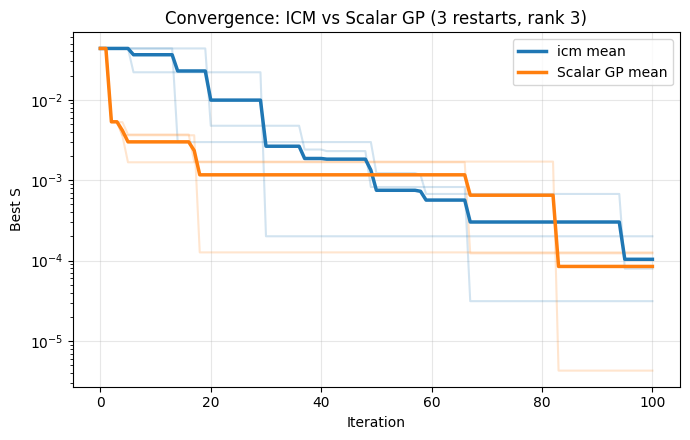

In [35]:

import matplotlib.pyplot as plt
import numpy as np


min_len = min(
    min(len(h) for h in icm_histories_raw),
    min(len(h) for h in vanilla_histories_raw),
)

xs = np.arange(min_len)

plt.figure(figsize=(7,4.5))


for h in icm_histories_raw:
    plt.plot(xs, np.array(h[:min_len]), color="tab:blue", alpha=0.2)

for h in vanilla_histories_raw:
    plt.plot(xs, np.array(h[:min_len]), color="tab:orange", alpha=0.2)

# Plot means (bold)
icm_mean = np.mean([h[:min_len] for h in icm_histories_raw], axis=0)
van_mean = np.mean([h[:min_len] for h in vanilla_histories_raw], axis=0)

plt.plot(xs, icm_mean, label="icm mean", color="tab:blue", linewidth=2.5)
plt.plot(xs, van_mean, label="Scalar GP mean", color="tab:orange", linewidth=2.5)



plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Best S")
plt.title("Convergence: ICM vs Scalar GP (3 restarts, rank 3)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
print("len(train_X_icm_init):", len(train_X_icm_init))
print("len(train_X_icm):", len(train_X_icm))
print("best raw init:", min(S_obs_history_raw_van))

len(train_X_icm_init): 20
len(train_X_icm): 120
best raw init: 0.00012317061191424727


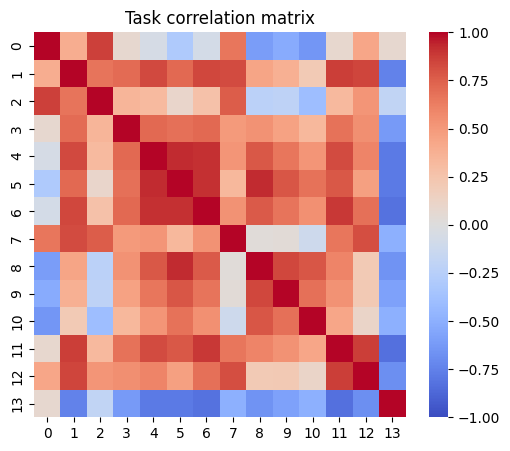

In [37]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(corr.cpu().numpy(), cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Task correlation matrix")
plt.show()

In [38]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()
    evals = torch.linalg.eigvalsh(B).flip(0)  # descending
    print(evals[:10])
    print("ratio e3/e2:", (evals[2] / evals[1]).item())


tensor([304.8551, 121.5099,  17.8924,   3.7021,   2.4562,   2.2242,   1.8896,
          1.8689,   1.7682,   1.5678])
ratio e3/e2: 0.14725035429000854


14.8057 / 25.8585 = 52 therefore rank‑3 could still capture meaningful structure

In [39]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor

    # Correct kappa
    kappa = task.var  # <-- correct

    B_lr = W @ W.t()
    B_d  = torch.diag(kappa)
    B    = B_lr + B_d

    frac_diag = torch.trace(B_d) / torch.trace(B)
    marg = torch.diag(B)
    frac_diag_per_task = kappa / marg

    print("Fraction diagonal:", frac_diag.item())
    print("diag fraction per task (min/mean/max/median):",
          frac_diag_per_task.min().item(),
          frac_diag_per_task.mean().item(),
          frac_diag_per_task.max().item(), 
          frac_diag_per_task.median().item()
          )
    print("first 10:", frac_diag_per_task[:])



Fraction diagonal: 0.051902055740356445
diag fraction per task (min/mean/max/median): 0.01054391823709011 0.12556245923042297 0.42575469613075256 0.06430266052484512
first 10: tensor([0.0246, 0.0153, 0.0643, 0.4258, 0.0810, 0.0105, 0.0762, 0.1592, 0.0180,
        0.2820, 0.3015, 0.0486, 0.0108, 0.2400])


In [40]:
frac = frac_diag_per_task.detach().cpu()
idx = torch.argsort(frac)  # lowest = most shared
for i in idx:
    print(i.item(), float(frac[i]))


5 0.01054391823709011
12 0.010847213678061962
1 0.015258467756211758
8 0.01801946945488453
0 0.02458188310265541
11 0.04857954755425453
2 0.06430266052484512
6 0.07623032480478287
4 0.08103309571743011
7 0.15920908749103546
13 0.24003811180591583
9 0.2820173501968384
10 0.30145859718322754
3 0.42575469613075256


In [41]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor  # [L, r]
    print("W (per-task loadings):")
    print(W)


W (per-task loadings):
Parameter containing:
tensor([[-2.9213,  2.8349, -5.3136],
        [ 6.2043,  5.0088, -5.7712],
        [-0.4224,  2.5742, -2.4939],
        [ 1.4826,  0.9052, -0.5619],
        [ 4.1389,  2.2334, -0.7309],
        [ 6.5988,  2.5946,  0.5271],
        [ 4.6864,  1.6655, -1.1939],
        [ 1.3589,  1.9786, -3.9213],
        [ 6.7324,  1.2656,  2.7077],
        [ 2.0191,  0.2157,  0.7001],
        [ 1.7152, -0.2650,  0.8033],
        [ 6.6076,  1.0108, -3.9010],
        [ 3.2202,  0.2557, -4.8418],
        [-2.0816, -0.3724,  0.6989]], requires_grad=True)


In [42]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor  # [L, r]

    # Safe way to get diagonal variance
    if hasattr(task, "raw_var") and hasattr(task, "raw_var_constraint"):
        kappa = task.raw_var_constraint.transform(task.raw_var)
    else:
        kappa = task.var  # fallback

    B_lr = W @ W.t()
    B_d  = torch.diag(kappa)
    B    = B_lr + B_d

    print("trace low-rank / trace total =", (torch.trace(B_lr) / torch.trace(B)).item())
    print("||B_lr||_F / ||B_total||_F =", (torch.linalg.norm(B_lr) / torch.linalg.norm(B)).item())
    print("frac diag =", (torch.trace(B_d) / torch.trace(B)).item())


trace low-rank / trace total = 0.9480979442596436
||B_lr||_F / ||B_total||_F = 0.9932377338409424
frac diag = 0.051902055740356445


In [43]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()  # <-- important

    evals, evecs = torch.linalg.eigh(B)  # ascending
    evals = torch.flip(evals, dims=[0])
    evecs = torch.flip(evecs, dims=[1])  # columns aligned with evals

print("Top eigenvalues:", evals[:5])
print("Top eigenvectors (first 3 modes):")
print(evecs[:, :3])


Top eigenvalues: tensor([304.8551, 121.5099,  17.8924,   3.7021,   2.4562])
Top eigenvectors (first 3 modes):
tensor([[-0.0405,  0.5979,  0.2617],
        [-0.5370,  0.2650,  0.2391],
        [-0.0910,  0.2642,  0.3404],
        [-0.1038, -0.0052,  0.0754],
        [-0.2640, -0.0849,  0.2202],
        [-0.3600, -0.2824,  0.2728],
        [-0.2891, -0.0875,  0.0156],
        [-0.1985,  0.2852, -0.0089],
        [-0.2892, -0.4837,  0.1908],
        [-0.0860, -0.1411,  0.0121],
        [-0.0587, -0.1454, -0.0696],
        [-0.4310,  0.0164, -0.5402],
        [-0.2699,  0.2238, -0.5366],
        [ 0.1242,  0.0340,  0.0914]])


In [44]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix
    evals = torch.linalg.eigvalsh(B).flip(0)   # descending
    print(evals[:10])
    print("λ4/λ3 =", (evals[3]/evals[2]).item())


tensor([304.8552, 121.5099,  17.8924,   3.7021,   2.4562,   2.2242,   1.8896,
          1.8689,   1.7682,   1.5678])
λ4/λ3 = 0.20690692961215973


In [47]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()  

    evals, evecs = torch.linalg.eigh(B)
    evals = torch.flip(evals, dims=[0])
    evecs = torch.flip(evecs, dims=[1])

    v4 = evecs[:, 3]
    print("v4:", v4)
    print("top |weights| indices:", torch.topk(v4.abs(), k=5).indices)



v4: tensor([ 0.1942,  0.1875,  0.0965,  0.0318,  0.0286, -0.0198,  0.0225, -0.9327,
        -0.0925, -0.0405, -0.0461,  0.1702,  0.0620, -0.0035])
top |weights| indices: tensor([ 7,  0,  1, 11,  2])


# KG 


In [68]:
import importlib
import MOGP.helpers_MOGP as helpers_MOGP
importlib.reload(helpers_MOGP)

ICMMultiOutputGP_KG = helpers_MOGP.ICMMultiOutputGP_KG

In [69]:
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
import torch
from MOGP.helpers_MOGP import ICMMultiOutputGP_KG
# reload helpers and re-create model
import importlib
import MOGP.helpers_MOGP as helpers_MOGP
importlib.reload(helpers_MOGP)
import importlib
import MOGP.helpers_MOGP as helpers_MOGP
importlib.reload(helpers_MOGP)
from MOGP.helpers_MOGP import initialize_icm_gp

from MOGP.helpers_MOGP import initialize_icm_gp

# re-create model
icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
icm_model = icm_model.to(device=device, dtype=dtype)
icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
mll = mll.to(device=device, dtype=dtype)
# uniform weights: [L]
L = icm_model.num_tasks
weights_uniform = torch.ones(L, device=bounds_norm.device, dtype=bounds_norm.dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

# minimize errors -> maximize negative weighted sum
objective = GenericMCObjective(
    lambda Y, X=None: -(Y * weights_uniform.view(1, 1, -1)).sum(dim=-1)
)


num_fantasies = 64
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_fantasies]))

icm_model.eval()
KG = qKnowledgeGradient(
    model=icm_model,
    num_fantasies=num_fantasies,
    sampler=sampler,
    objective=objective,
)

with torch.no_grad():
    candidate, acq_val = optimize_acqf(
        acq_function=KG,
        bounds=bounds_norm,
        q=1,
        num_restarts=config["NUM_RESTARTS"],
        raw_samples=config["RAW_SAMPLES"],
    )

candidate = candidate.detach()
print("KG candidate (normalized):", candidate)
print("KG value:", acq_val.item())

RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([64, 32, 1694]), while the reported shape of the mean is torch.Size([64, 64, 32, 121, 14]).

In [ ]:
import torch
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf

def suggest_next_x_kg(
    model,
    bounds_norm,
    weights,
    num_fantasies=64,
    sampler_mc=128,
    num_restarts=20,
    raw_samples=512,
):
    # weights: [L]
    weights = torch.as_tensor(weights, device=bounds_norm.device, dtype=bounds_norm.dtype).view(-1)
    weights = weights / weights.sum()

    # BoTorch maximizes; if Y are errors to minimize -> maximize negative weighted sum
    objective = GenericMCObjective(
        lambda Y, X=None: -(Y * weights.view(1, 1, -1)).sum(dim=-1)
    )

    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_fantasies]))

    model.eval()
    KG = qKnowledgeGradient(
        model=model,
        num_fantasies=num_fantasies,
        sampler=sampler,
        objective=objective,
    )

    with torch.no_grad():
        x_next_norm, acq_val = optimize_acqf(
            acq_function=KG,
            bounds=bounds_norm,
            q=1,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return x_next_norm.detach(), acq_val
